In [1]:
import pandas as pd 
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [3]:
train = pd.read_csv('../data_2023_1213/train_concat.csv')

ex1 = pd.read_excel('../data_0403/용인.xlsx')

In [4]:
len(ex1)

632

In [5]:
ex1[['pcr_urine','pcr_urine.1']].describe()

,pcr_urine,pcr_urine.1
count,632.000000,632.000000
mean,838.241297,0.838241
std,2134.380017,2.134379
min,26.000000,0.026000
25%,61.425000,0.061425
50%,109.800000,0.109800
75%,440.525000,0.440525
max,16468.100000,16.468100


In [6]:
ex1.columns = ['연구등록번호', '(실명)등록번호', 'age', 'sex', 'HTN', 'DM', 'tpro', 'alb', 'chol',
       'bun', 'cr', 'eGFR', 'glu', 'plt', 'blood_dip', 'protein_dip',
       'acr_urine', 'pcr_', 'pcr_urine', 'Dysmorphic RBC',
       'G1 dysmorphic', 'glu_urine', 'esterase_urine', 'RBC', 'WBC', 'Biopsy',
       'Reason', 'Biopsy_new', 'pred', 'pred_prob_1', 'pred_prob_0']
ex1.columns

Index(['연구등록번호', '(실명)등록번호', 'age', 'sex', 'HTN', 'DM', 'tpro', 'alb', 'chol',
       'bun', 'cr', 'eGFR', 'glu', 'plt', 'blood_dip', 'protein_dip',
       'acr_urine', 'pcr_', 'pcr_urine', 'Dysmorphic RBC', 'G1 dysmorphic',
       'glu_urine', 'esterase_urine', 'RBC', 'WBC', 'Biopsy', 'Reason',
       'Biopsy_new', 'pred', 'pred_prob_1', 'pred_prob_0'],
      dtype='object')

In [7]:
ex_copy = ex1[['age', 'sex', 'HTN', 'DM', 'plt', 'alb',
       'bun', 'cr', 'eGFR', 'blood_dip', 'protein_dip',
       'acr_urine', 'pcr_urine', 'glu', 'RBC', 'WBC','Biopsy','Biopsy_new']].copy()
print(ex_copy.columns)
ex_copy.head()

Index(['age', 'sex', 'HTN', 'DM', 'plt', 'alb', 'bun', 'cr', 'eGFR',
       'blood_dip', 'protein_dip', 'acr_urine', 'pcr_urine', 'glu', 'RBC',
       'WBC', 'Biopsy', 'Biopsy_new'],
      dtype='object')


,age,sex,HTN,DM,plt,alb,bun,cr,eGFR,blood_dip,protein_dip,acr_urine,pcr_urine,glu,RBC,WBC,Biopsy,Biopsy_new
0,52,1,1,0,230,4.5,18.2,1.02,84.112709,2.0,1.0,328.3,0.8571,104,20,2,1,1
1,38,1,0,0,441,4.4,14.0,1.02,92.805164,3.0,3.0,1224.4,1.8593,88,20,2,0,1
2,43,1,1,1,196,4.5,9.8,0.62,121.494743,0.0,2.0,185.6,0.2984,276,2,2,0,0
3,41,1,1,0,283,4.1,25.6,1.44,59.890404,0.0,0.0,8.0,0.0382,104,2,2,0,0
4,62,1,0,0,186,4.4,14.2,0.65,104.269863,0.0,0.0,8.0,0.1232,90,2,2,0,0


In [8]:
print(train.shape)

print(ex_copy.shape)

(18513, 25)
(632, 18)


In [9]:
train_columns = set(train.columns)
ex1_columns = set(ex_copy.columns)

variable_difference = train_columns - ex1_columns
print(f"train 변수에서 validation 변수 제외한 변수들:{list(variable_difference)}")

train 변수에서 validation 변수 제외한 변수들:['RBC_re', 'group', 'RBC_binary', 'dysmorphism', 'esterase_urine', 'WBC_re', 'target', 'esterase_binary', 'WBC_binary', 'glu_urine', 'tpro']


In [10]:
train.columns = ['age', 'sex', 'HTN', 'DM', 'plt', 'tpro', 'alb', 'bun', 'cr', 'eGFR',
       'blood_dip', 'protein_dip', 'acr_urine', 'pcr_urine', 'glu',
       'glu_urine', 'esterase_urine', 'dysmorphism', 'RBC', 'WBC',
       'RBC_binary', 'WBC_binary', 'esterase_binary', 'group', 'target']

train.columns

Index(['age', 'sex', 'HTN', 'DM', 'plt', 'tpro', 'alb', 'bun', 'cr', 'eGFR',
       'blood_dip', 'protein_dip', 'acr_urine', 'pcr_urine', 'glu',
       'glu_urine', 'esterase_urine', 'dysmorphism', 'RBC', 'WBC',
       'RBC_binary', 'WBC_binary', 'esterase_binary', 'group', 'target'],
      dtype='object')

In [11]:
print(ex_copy['WBC'].value_counts())
ex_copy['RBC'].value_counts()

WBC
2     471
5      80
20     28
10     24
30     24
0       4
3       1
Name: count, dtype: int64


RBC
2     411
5      77
30     71
20     38
10     35
Name: count, dtype: int64

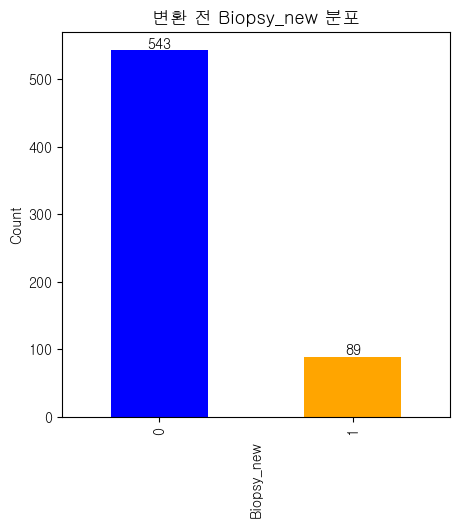

In [12]:
import matplotlib.pyplot as plt

# Bar plot of ex_copy.Biopsy_new
plt.figure(figsize=(5, 5))
ax = ex_copy['Biopsy_new'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.xlabel('Biopsy_new', rotation='vertical')
plt.ylabel('Count')

# Add count labels
for i, count in enumerate(ex_copy['Biopsy_new'].value_counts()):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.title('변환 전 Biopsy_new 분포', fontsize=13)
plt.show()


In [13]:
test = ex_copy.drop(['Biopsy','Biopsy_new'], axis=1).copy()
test.head()

,age,sex,HTN,DM,plt,alb,bun,cr,eGFR,blood_dip,protein_dip,acr_urine,pcr_urine,glu,RBC,WBC
0,52,1,1,0,230,4.5,18.2,1.02,84.112709,2.0,1.0,328.3,0.8571,104,20,2
1,38,1,0,0,441,4.4,14.0,1.02,92.805164,3.0,3.0,1224.4,1.8593,88,20,2
2,43,1,1,1,196,4.5,9.8,0.62,121.494743,0.0,2.0,185.6,0.2984,276,2,2
3,41,1,1,0,283,4.1,25.6,1.44,59.890404,0.0,0.0,8.0,0.0382,104,2,2
4,62,1,0,0,186,4.4,14.2,0.65,104.269863,0.0,0.0,8.0,0.1232,90,2,2


## Modeling_Biopsy

In [14]:
xgb = XGBClassifier(random_state = 2023, n_jobs=-1)

In [15]:
print(test.columns)
print(train.columns)

Index(['age', 'sex', 'HTN', 'DM', 'plt', 'alb', 'bun', 'cr', 'eGFR',
       'blood_dip', 'protein_dip', 'acr_urine', 'pcr_urine', 'glu', 'RBC',
       'WBC'],
      dtype='object')
Index(['age', 'sex', 'HTN', 'DM', 'plt', 'tpro', 'alb', 'bun', 'cr', 'eGFR',
       'blood_dip', 'protein_dip', 'acr_urine', 'pcr_urine', 'glu',
       'glu_urine', 'esterase_urine', 'dysmorphism', 'RBC', 'WBC',
       'RBC_binary', 'WBC_binary', 'esterase_binary', 'group', 'target'],
      dtype='object')


In [16]:
column_difference = set(ex_copy.columns).difference(set(train.columns))
print(f'val - train:{column_difference}')

column_difference = set(train.columns).difference(set(ex_copy.columns))
print(f'train - val:{column_difference}')

val - train:{'Biopsy', 'Biopsy_new'}
train - val:{'group', 'RBC_binary', 'dysmorphism', 'esterase_urine', 'target', 'esterase_binary', 'WBC_binary', 'glu_urine', 'tpro'}


In [17]:
X_train = train.drop(['tpro', 'esterase_binary', 'group', 'dysmorphism', 'WBC_binary',
                       'esterase_urine', 'RBC_binary', 'target', 'glu_urine'], axis=1).copy()
y_train = train['target'].copy()

In [18]:
X_train.columns

Index(['age', 'sex', 'HTN', 'DM', 'plt', 'alb', 'bun', 'cr', 'eGFR',
       'blood_dip', 'protein_dip', 'acr_urine', 'pcr_urine', 'glu', 'RBC',
       'WBC'],
      dtype='object')

In [19]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=2023, ...)

### train 결과

In [20]:
import shap
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train)

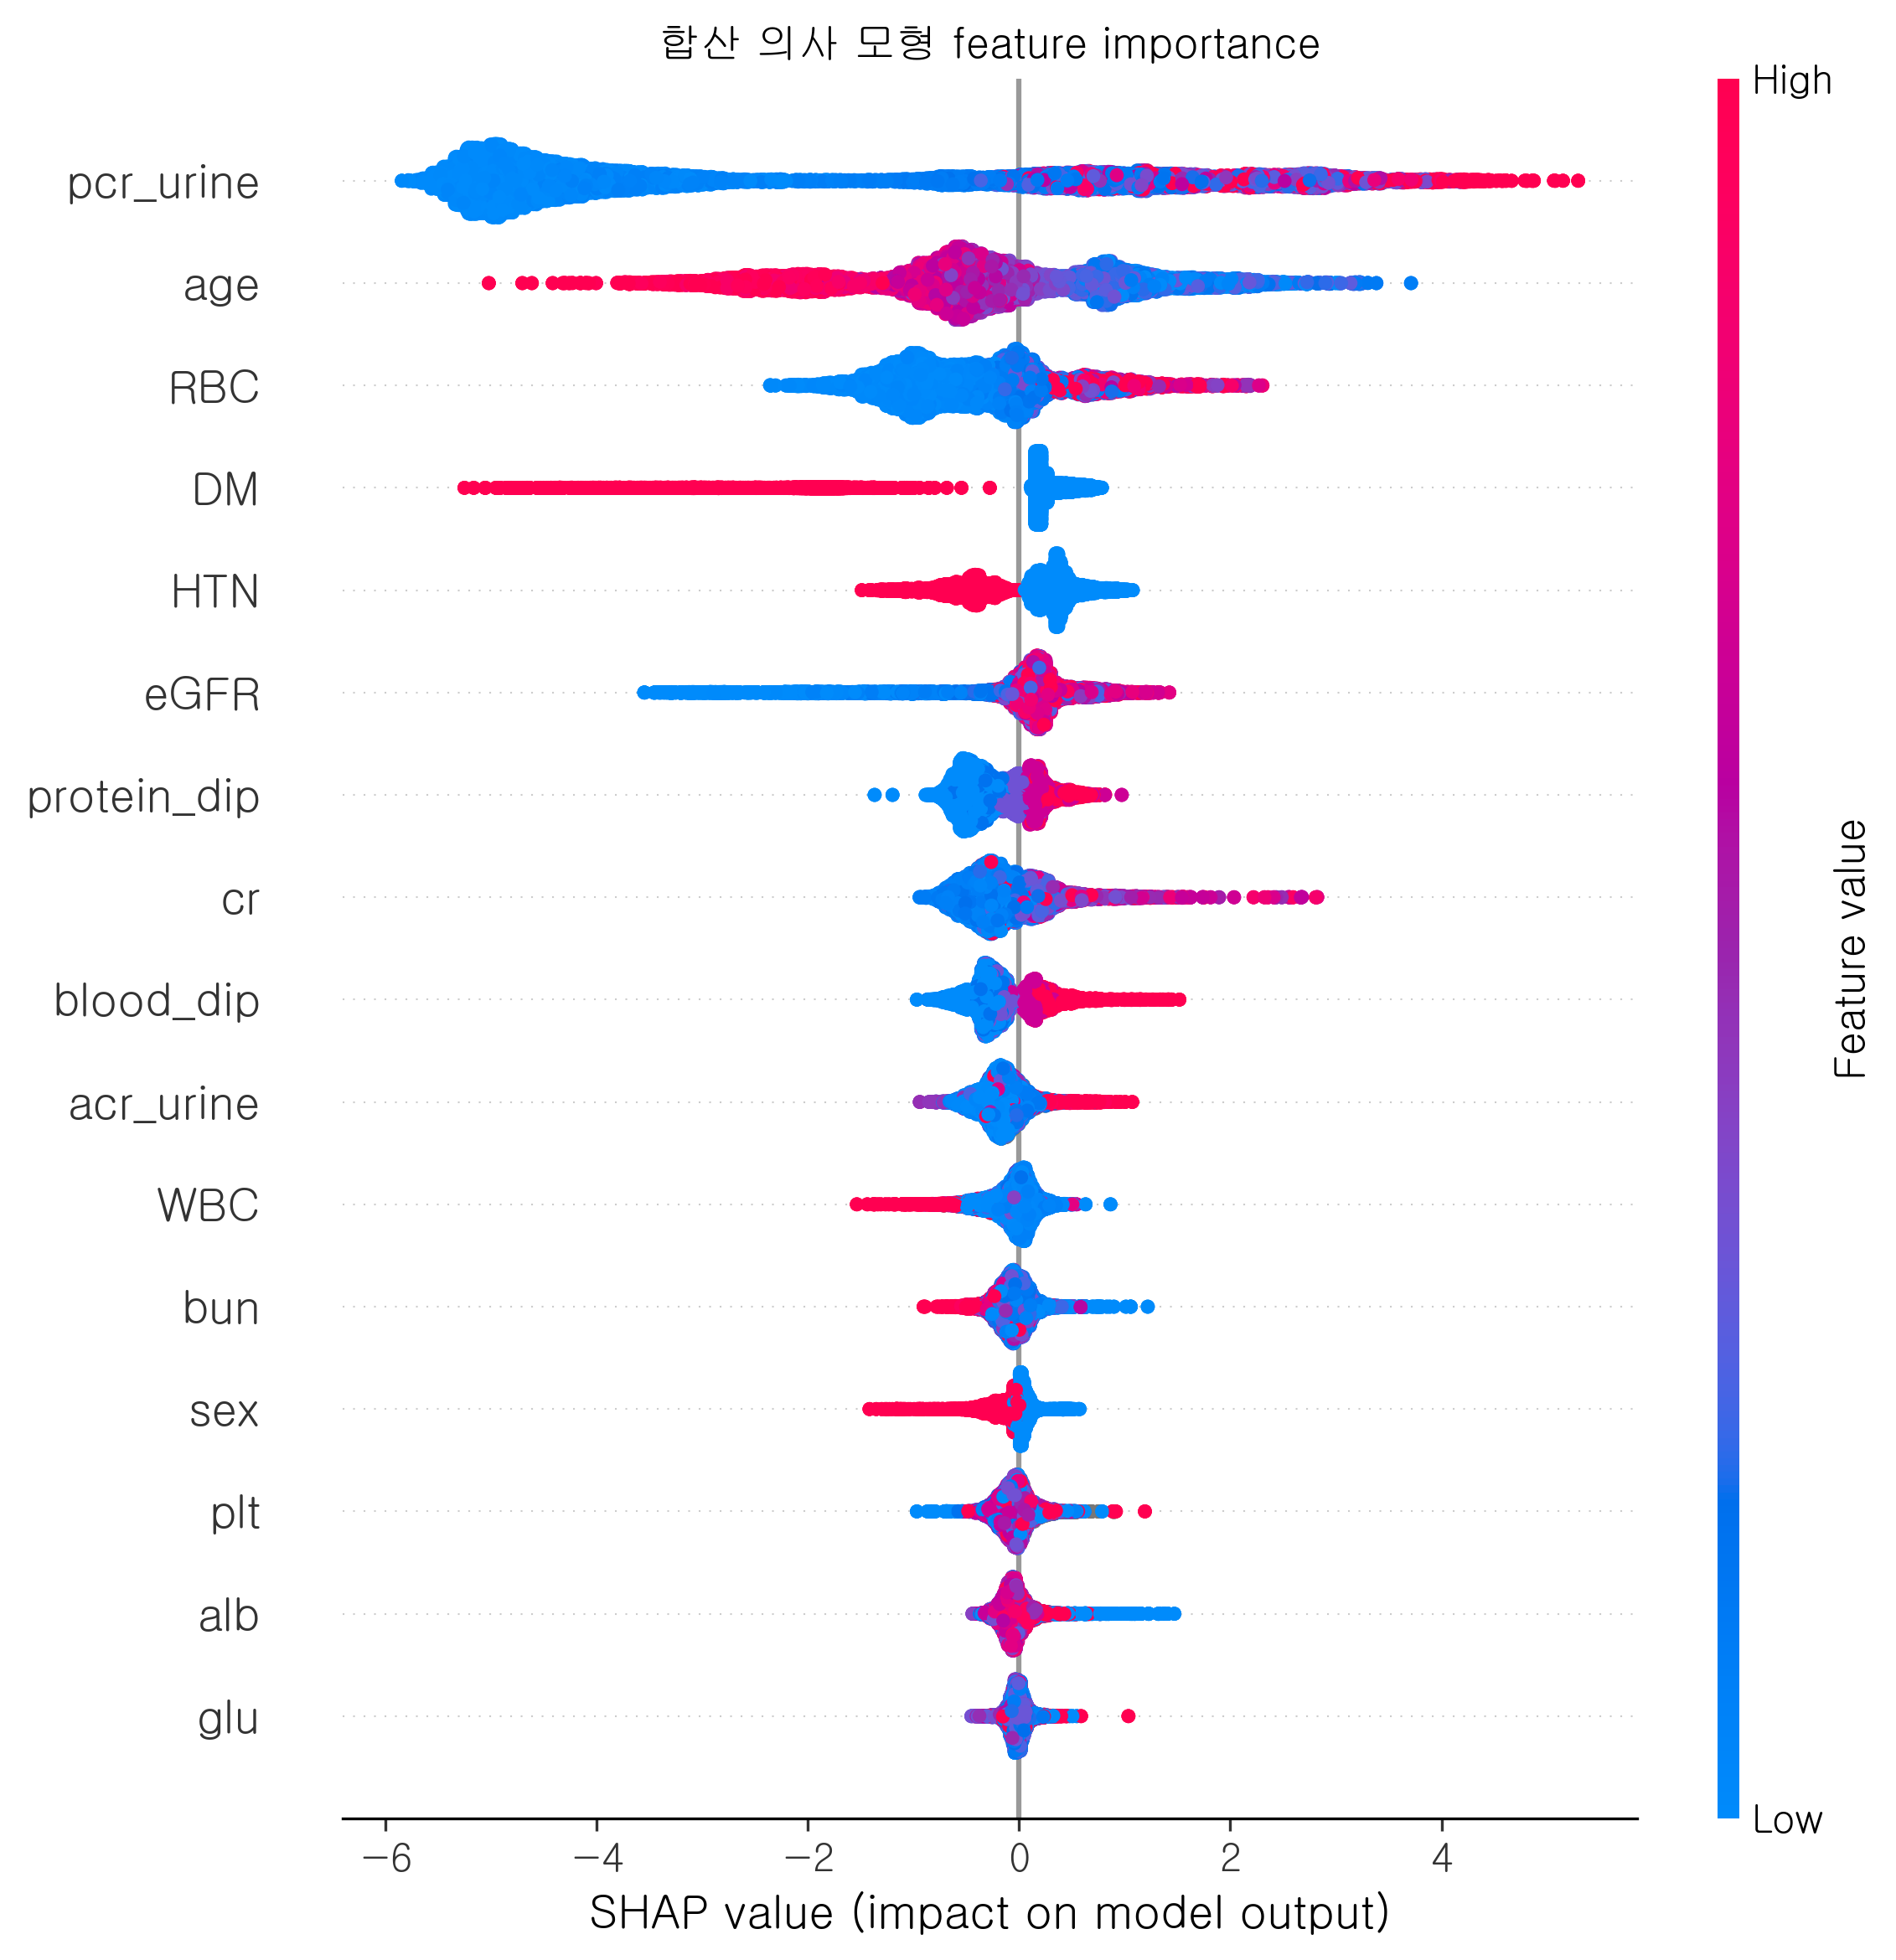

In [22]:
plt.figure(figsize=[10,10], dpi=300)

plt.title('합산 의사 모형 feature importance')
shap.summary_plot(shap_values, X_train)

plt.show()

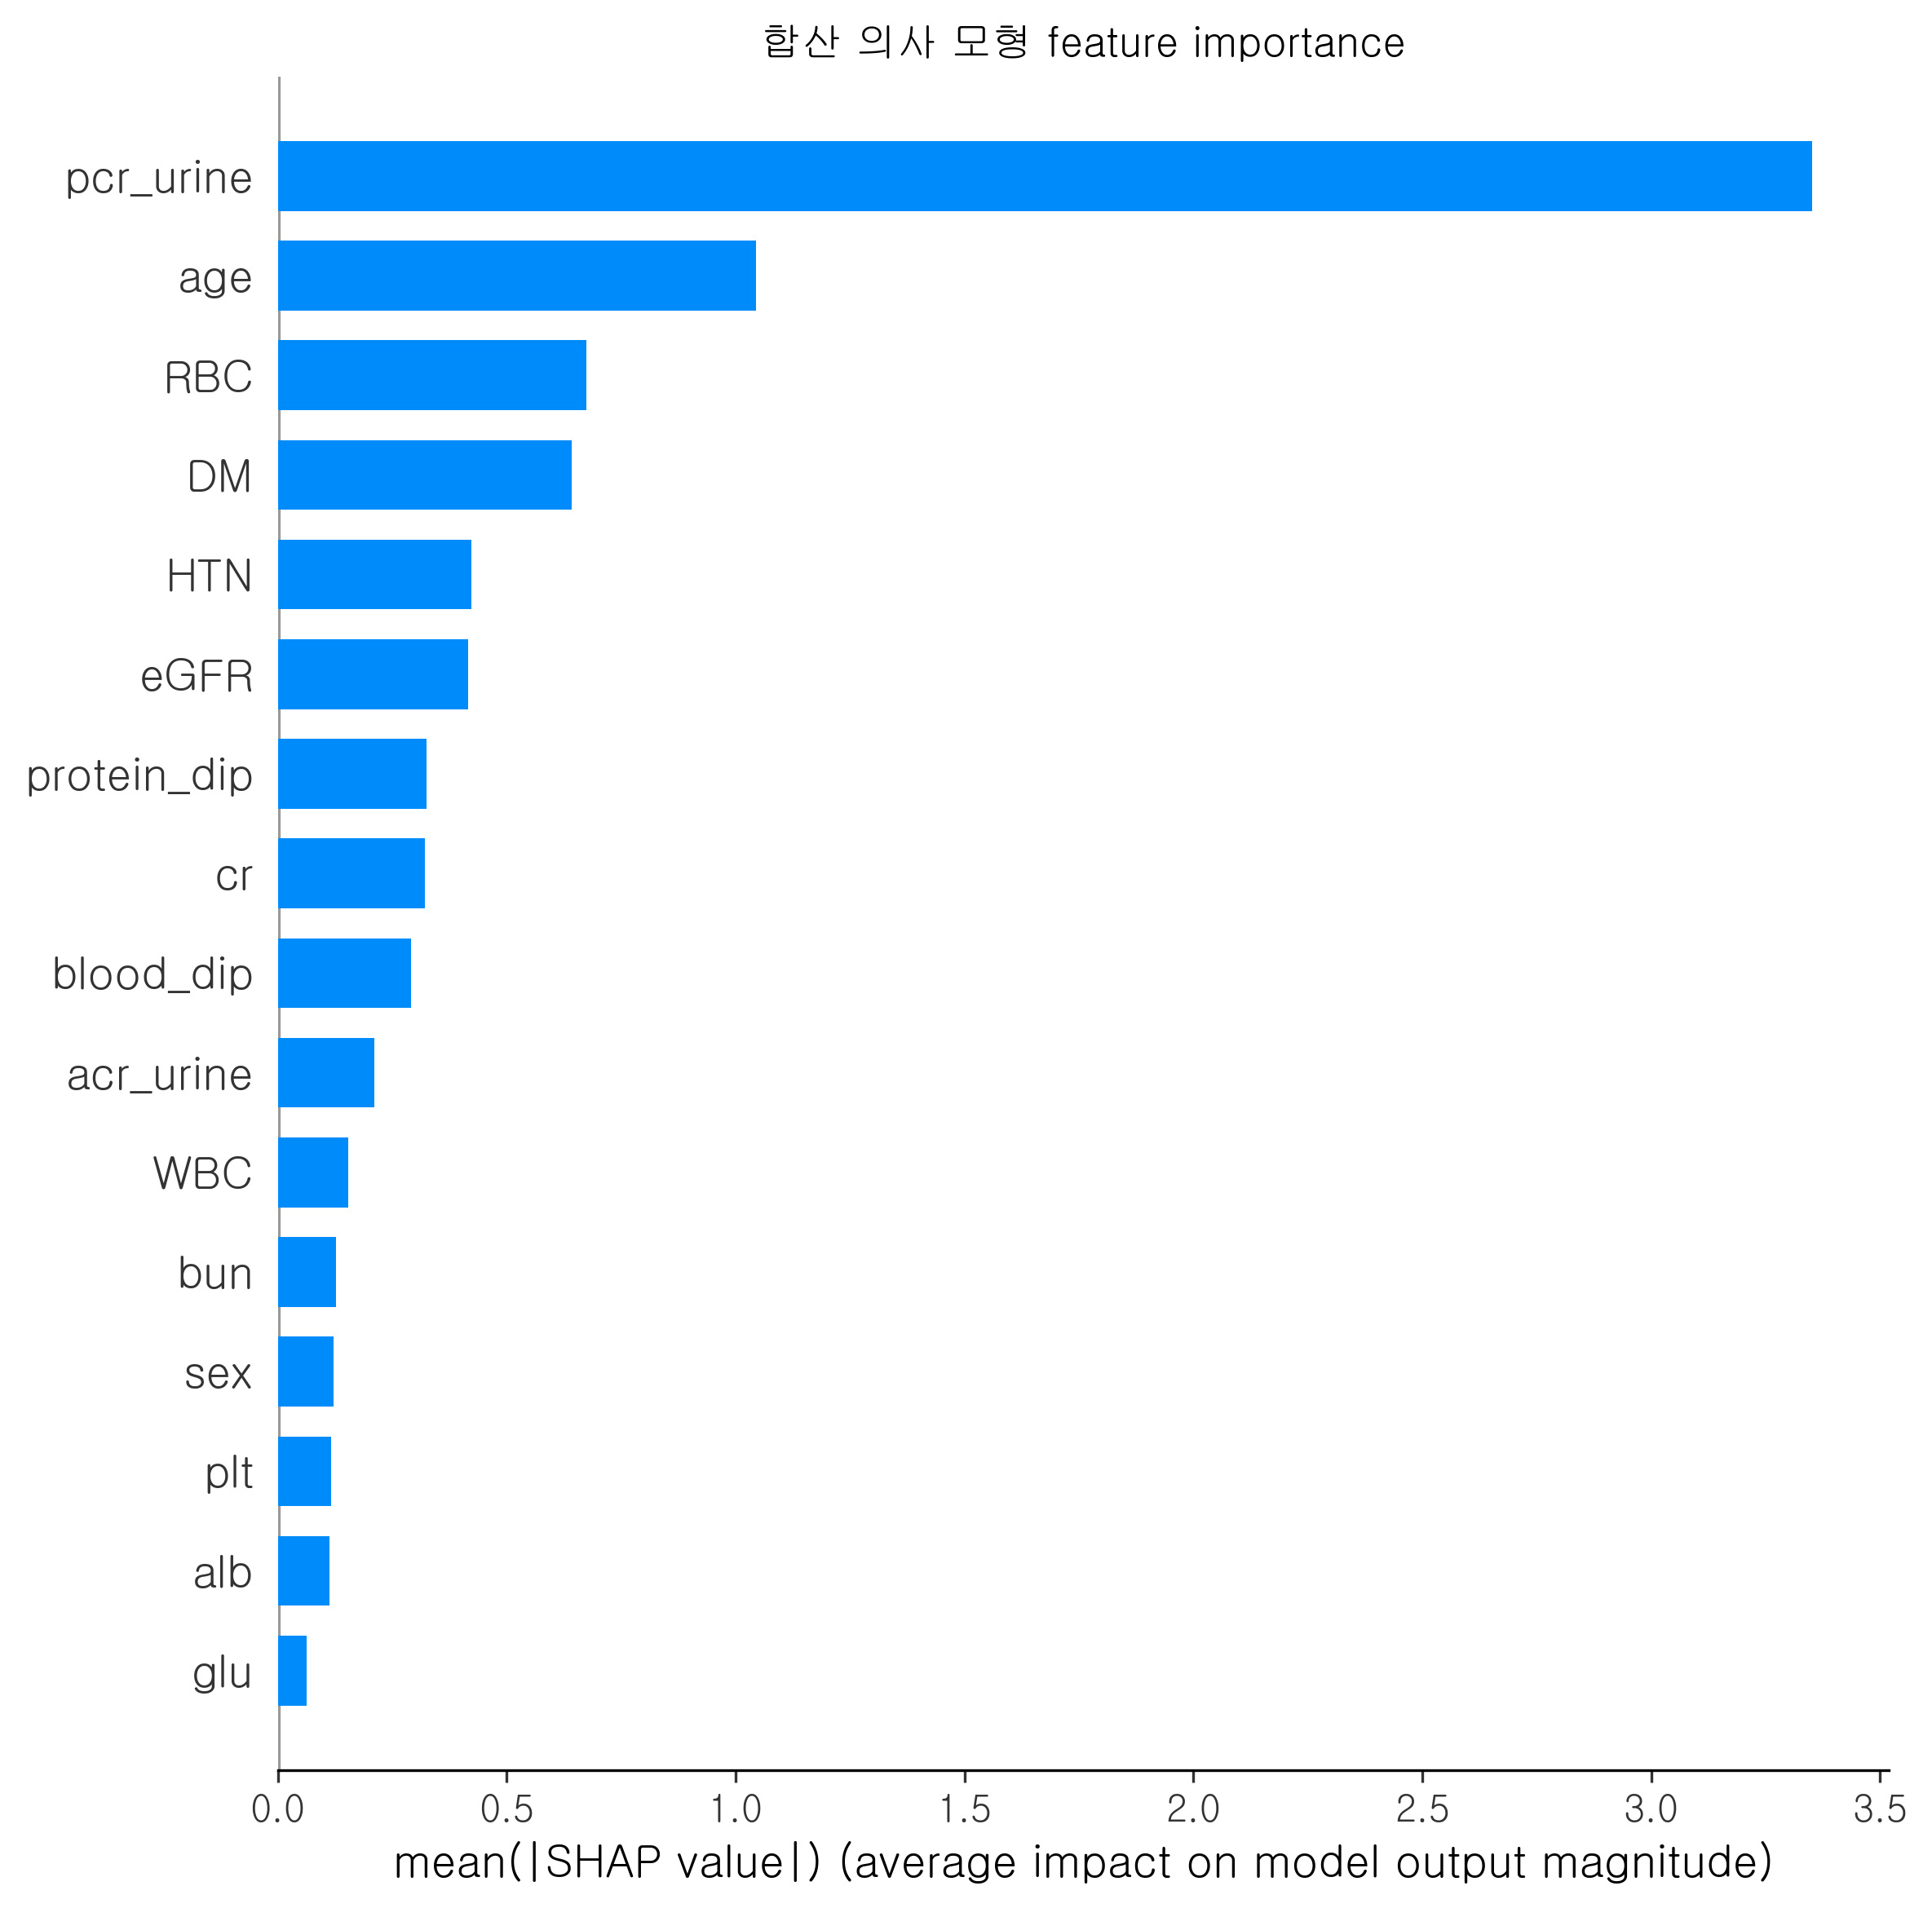

In [23]:
plt.figure(figsize=[10,10], dpi=300)

plt.title('합산 의사 모형 feature importance')
shap.summary_plot(shap_values, X_train, plot_type="bar")
plt.show()

In [24]:
train_pred = xgb.predict(X_train)
train_pred_prob = xgb.predict_proba(X_train)

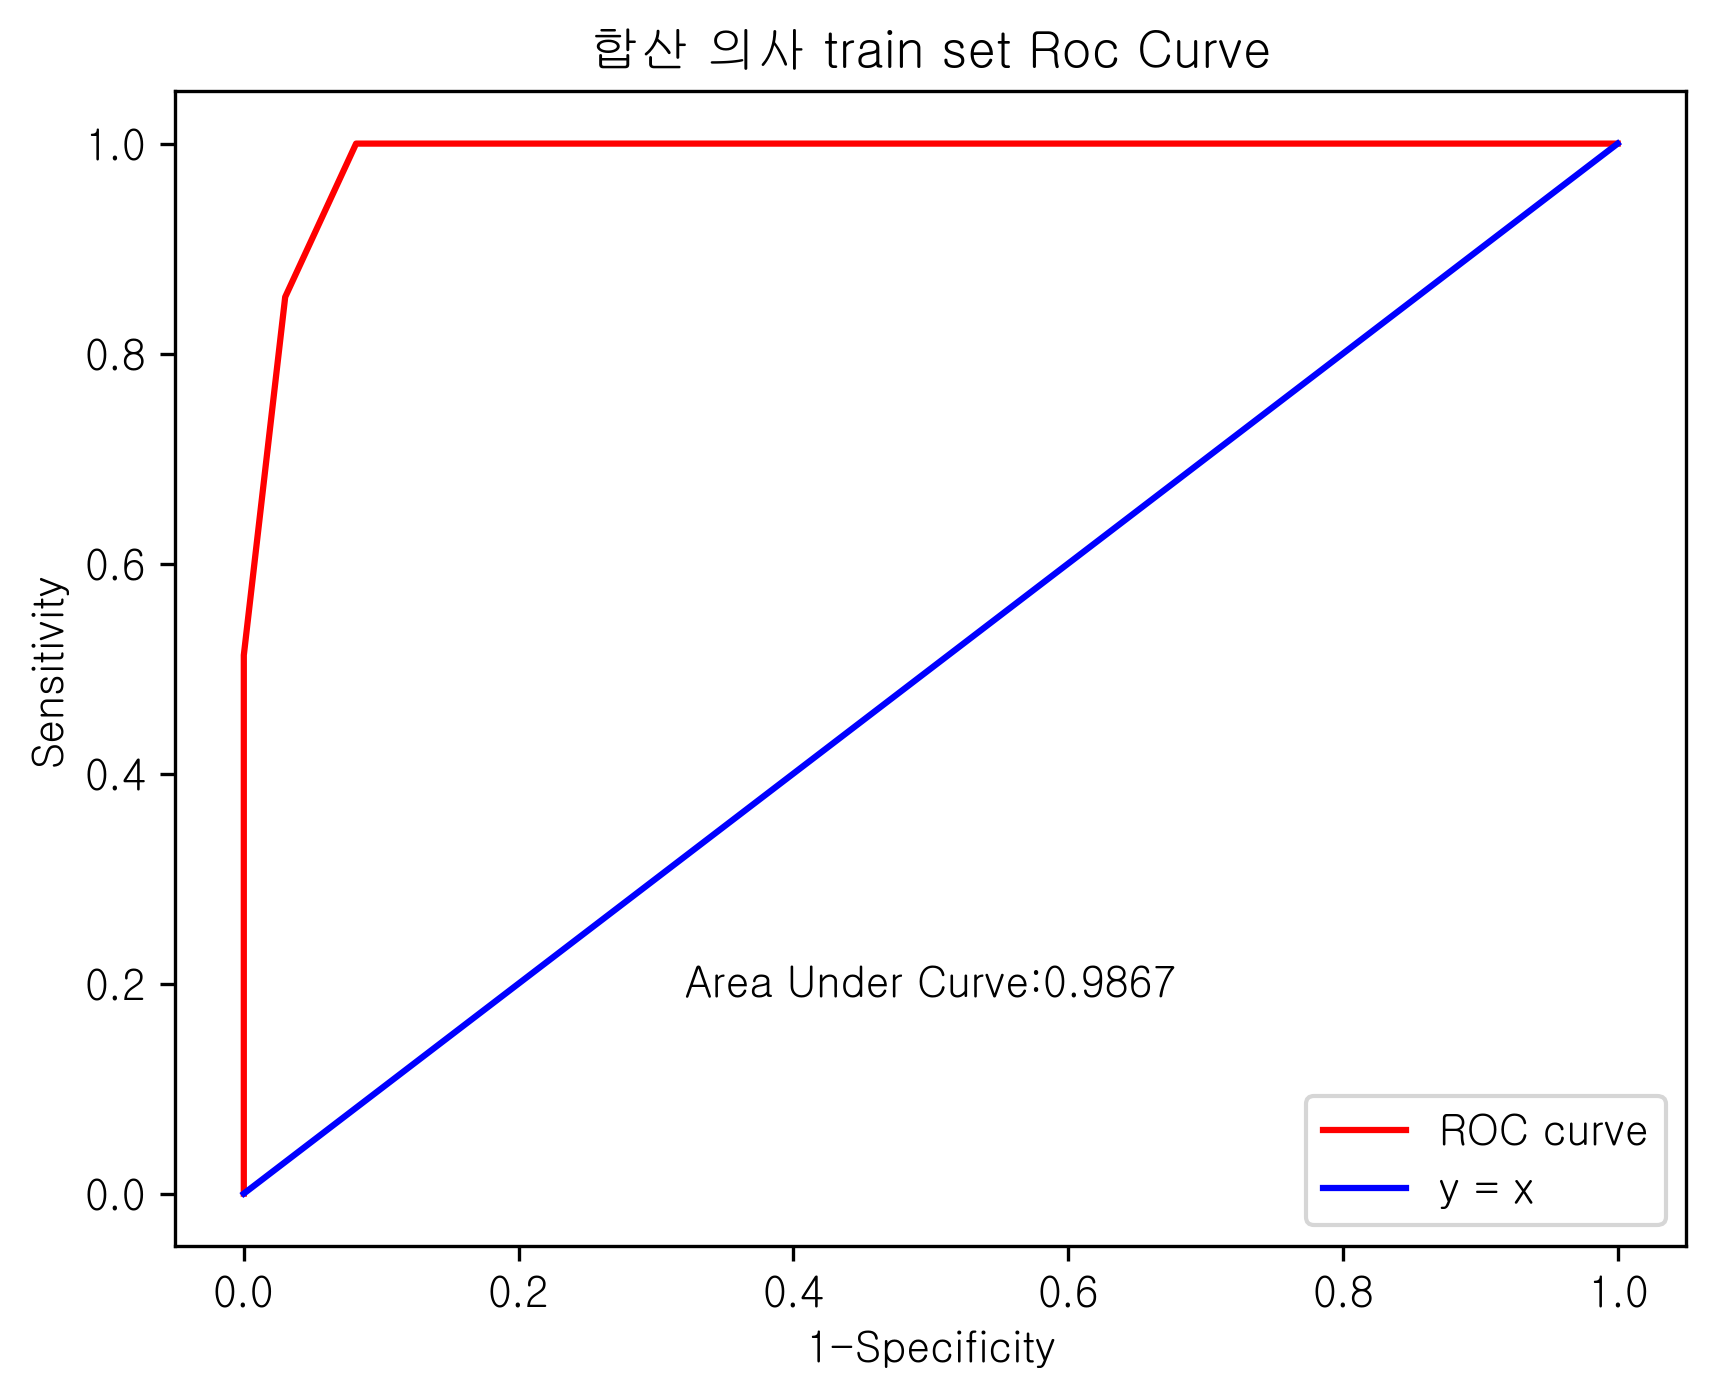

In [26]:
# roc curve, auc validation set
fpr, tpr, thresholds = roc_curve(np.array(y_train), train_pred_prob[:,1])

# auc 계산

plt.figure(figsize=(6.5, 5), dpi=300)
plt.plot(fpr, tpr, color = 'red', label = 'ROC curve')
plt.plot([0, 1], [0, 1], color = 'blue', label = 'y = x') # y = x 직선 표시

auc = roc_auc_score(np.array(y_train), train_pred_prob[:,1])
plt.text(0.5, 0.2, f"Area Under Curve:{auc:.4f}", ha='center', va='center', fontsize=10)
plt.title('합산 의사 train set Roc Curve')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')

plt.legend() # 그래프 라벨 표시

plt.show()

In [27]:
print(classification_report(y_train, train_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     15734
           1       0.83      0.85      0.84      2779

    accuracy                           0.95     18513
   macro avg       0.90      0.91      0.91     18513
weighted avg       0.95      0.95      0.95     18513



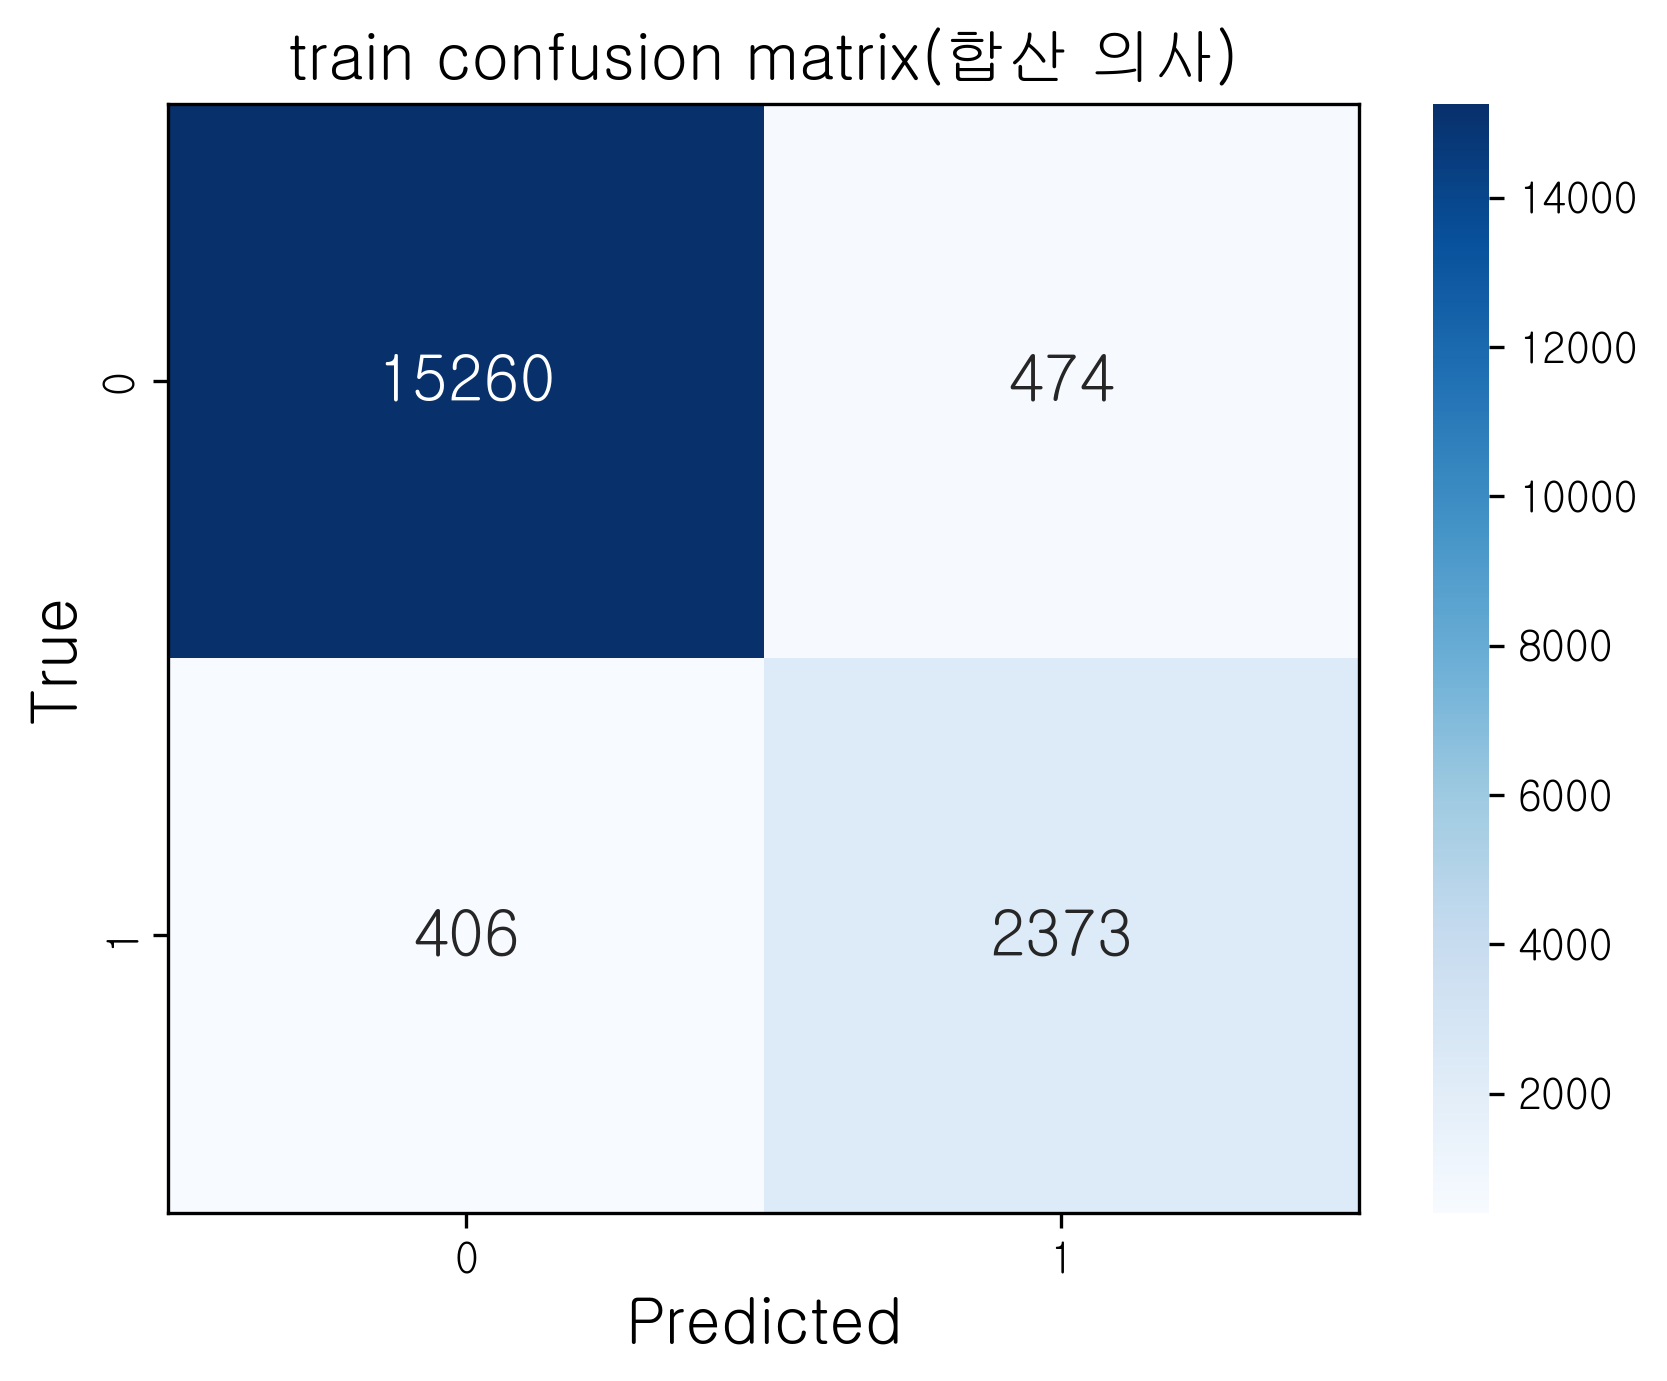

In [28]:
cm = confusion_matrix(y_train, train_pred)

plt.figure(dpi=300)
# Plot the confusion matrix with specific formatting for annotations
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Accessing the text elements of the heatmap and setting font properties
for _, spine in heatmap.spines.items():
    spine.set_visible(True)

for t in heatmap.texts:
    t.set_fontsize(15)  # Set the font size here

plt.title('train confusion matrix(합산 의사)', fontsize = 15)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)
plt.show()

### test

In [29]:
test_pred = xgb.predict(test)
test_pred_prob = xgb.predict_proba(test)

In [30]:
ex_copy['pred'] = test_pred
ex_copy['pred_prob'] = test_pred_prob[:,1]

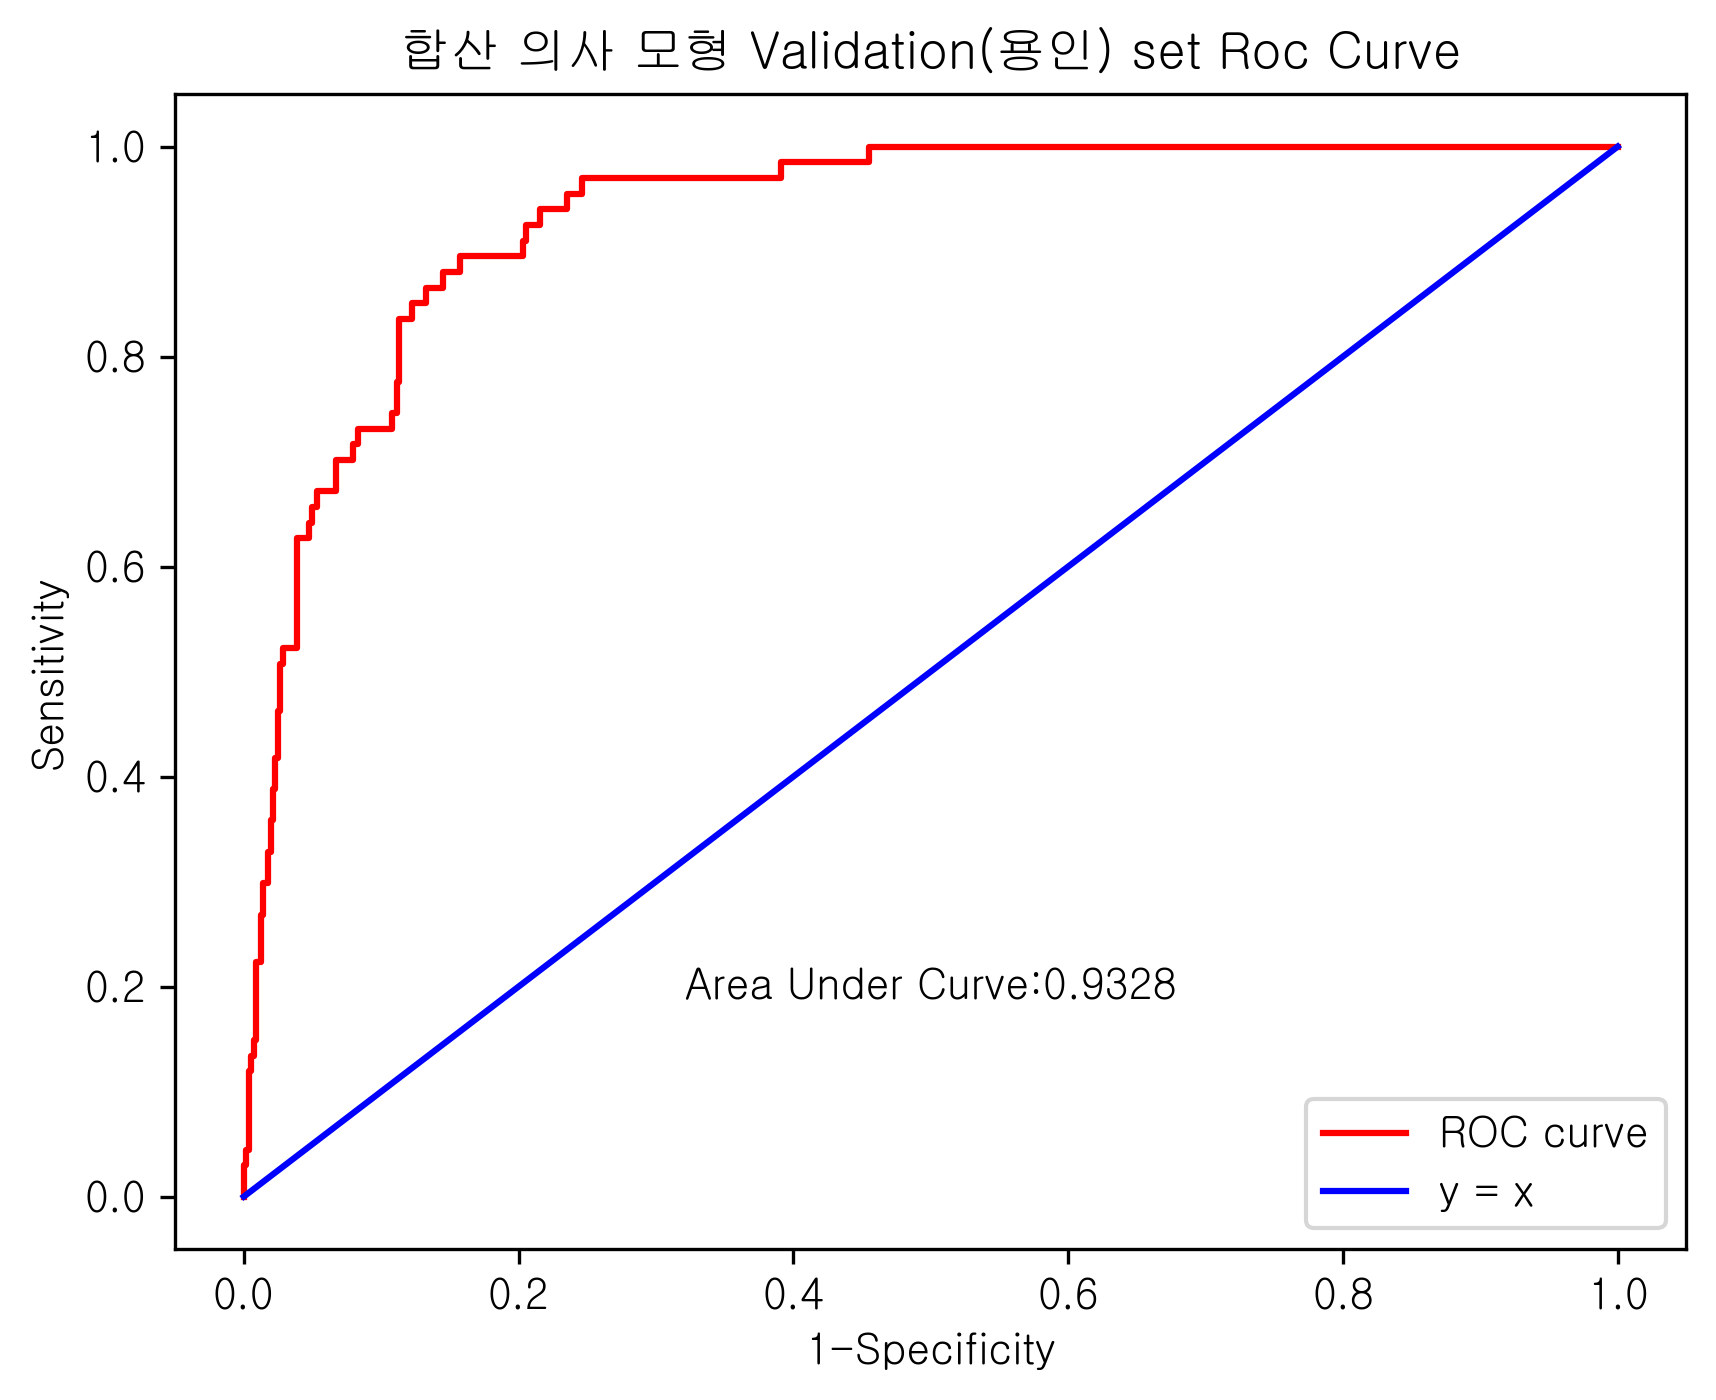

In [33]:
# roc curve, auc validation set
fpr, tpr, thresholds = roc_curve(np.array(ex_copy['Biopsy']), test_pred_prob[:,1])

plt.figure(figsize=(6.5, 5), dpi=300)
plt.plot(fpr, tpr, color = 'red', label = 'ROC curve')
plt.plot([0, 1], [0, 1], color = 'blue', label = 'y = x') # y = x 직선 표시

auc = roc_auc_score(np.array(ex_copy['Biopsy']), test_pred_prob[:,1])
plt.text(0.5, 0.2, f"Area Under Curve:{auc:.4f}", ha='center', va='center', fontsize=10)

plt.title('합산 의사 모형 Validation(용인) set Roc Curve')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.legend() # 그래프 라벨 표시

plt.show()

In [34]:
print(classification_report(ex_copy['Biopsy'], test_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       565
           1       0.62      0.54      0.58        67

    accuracy                           0.92       632
   macro avg       0.78      0.75      0.76       632
weighted avg       0.91      0.92      0.91       632



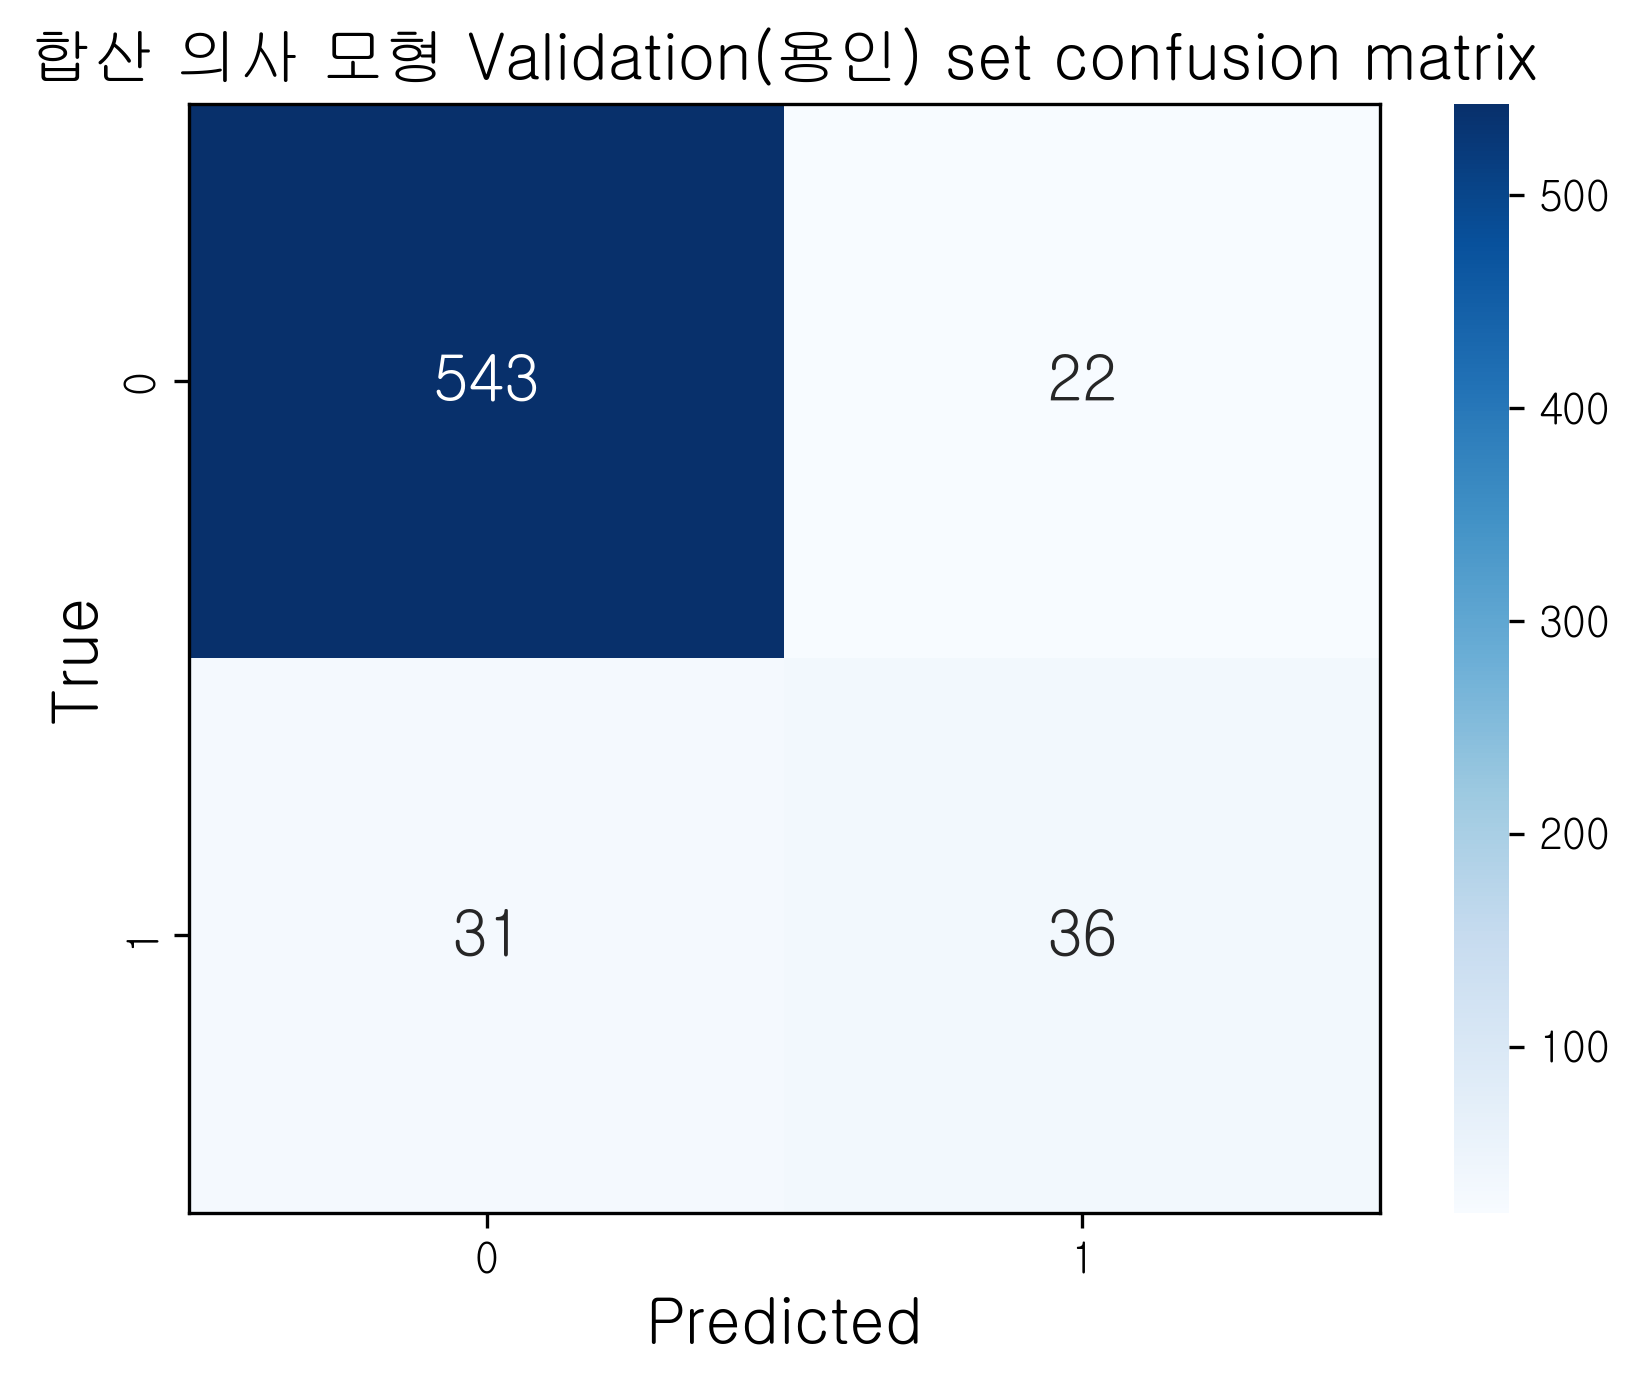

In [36]:
cm = confusion_matrix(ex_copy['Biopsy'], test_pred)

plt.figure(dpi=300)
# Plot the confusion matrix with specific formatting for annotations
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Accessing the text elements of the heatmap and setting font properties
for _, spine in heatmap.spines.items():
    spine.set_visible(True)

for t in heatmap.texts:
    t.set_fontsize(15)  # Set the font size here

plt.title('합산 의사 모형 Validation(용인) set confusion matrix', fontsize = 15)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)
plt.show()

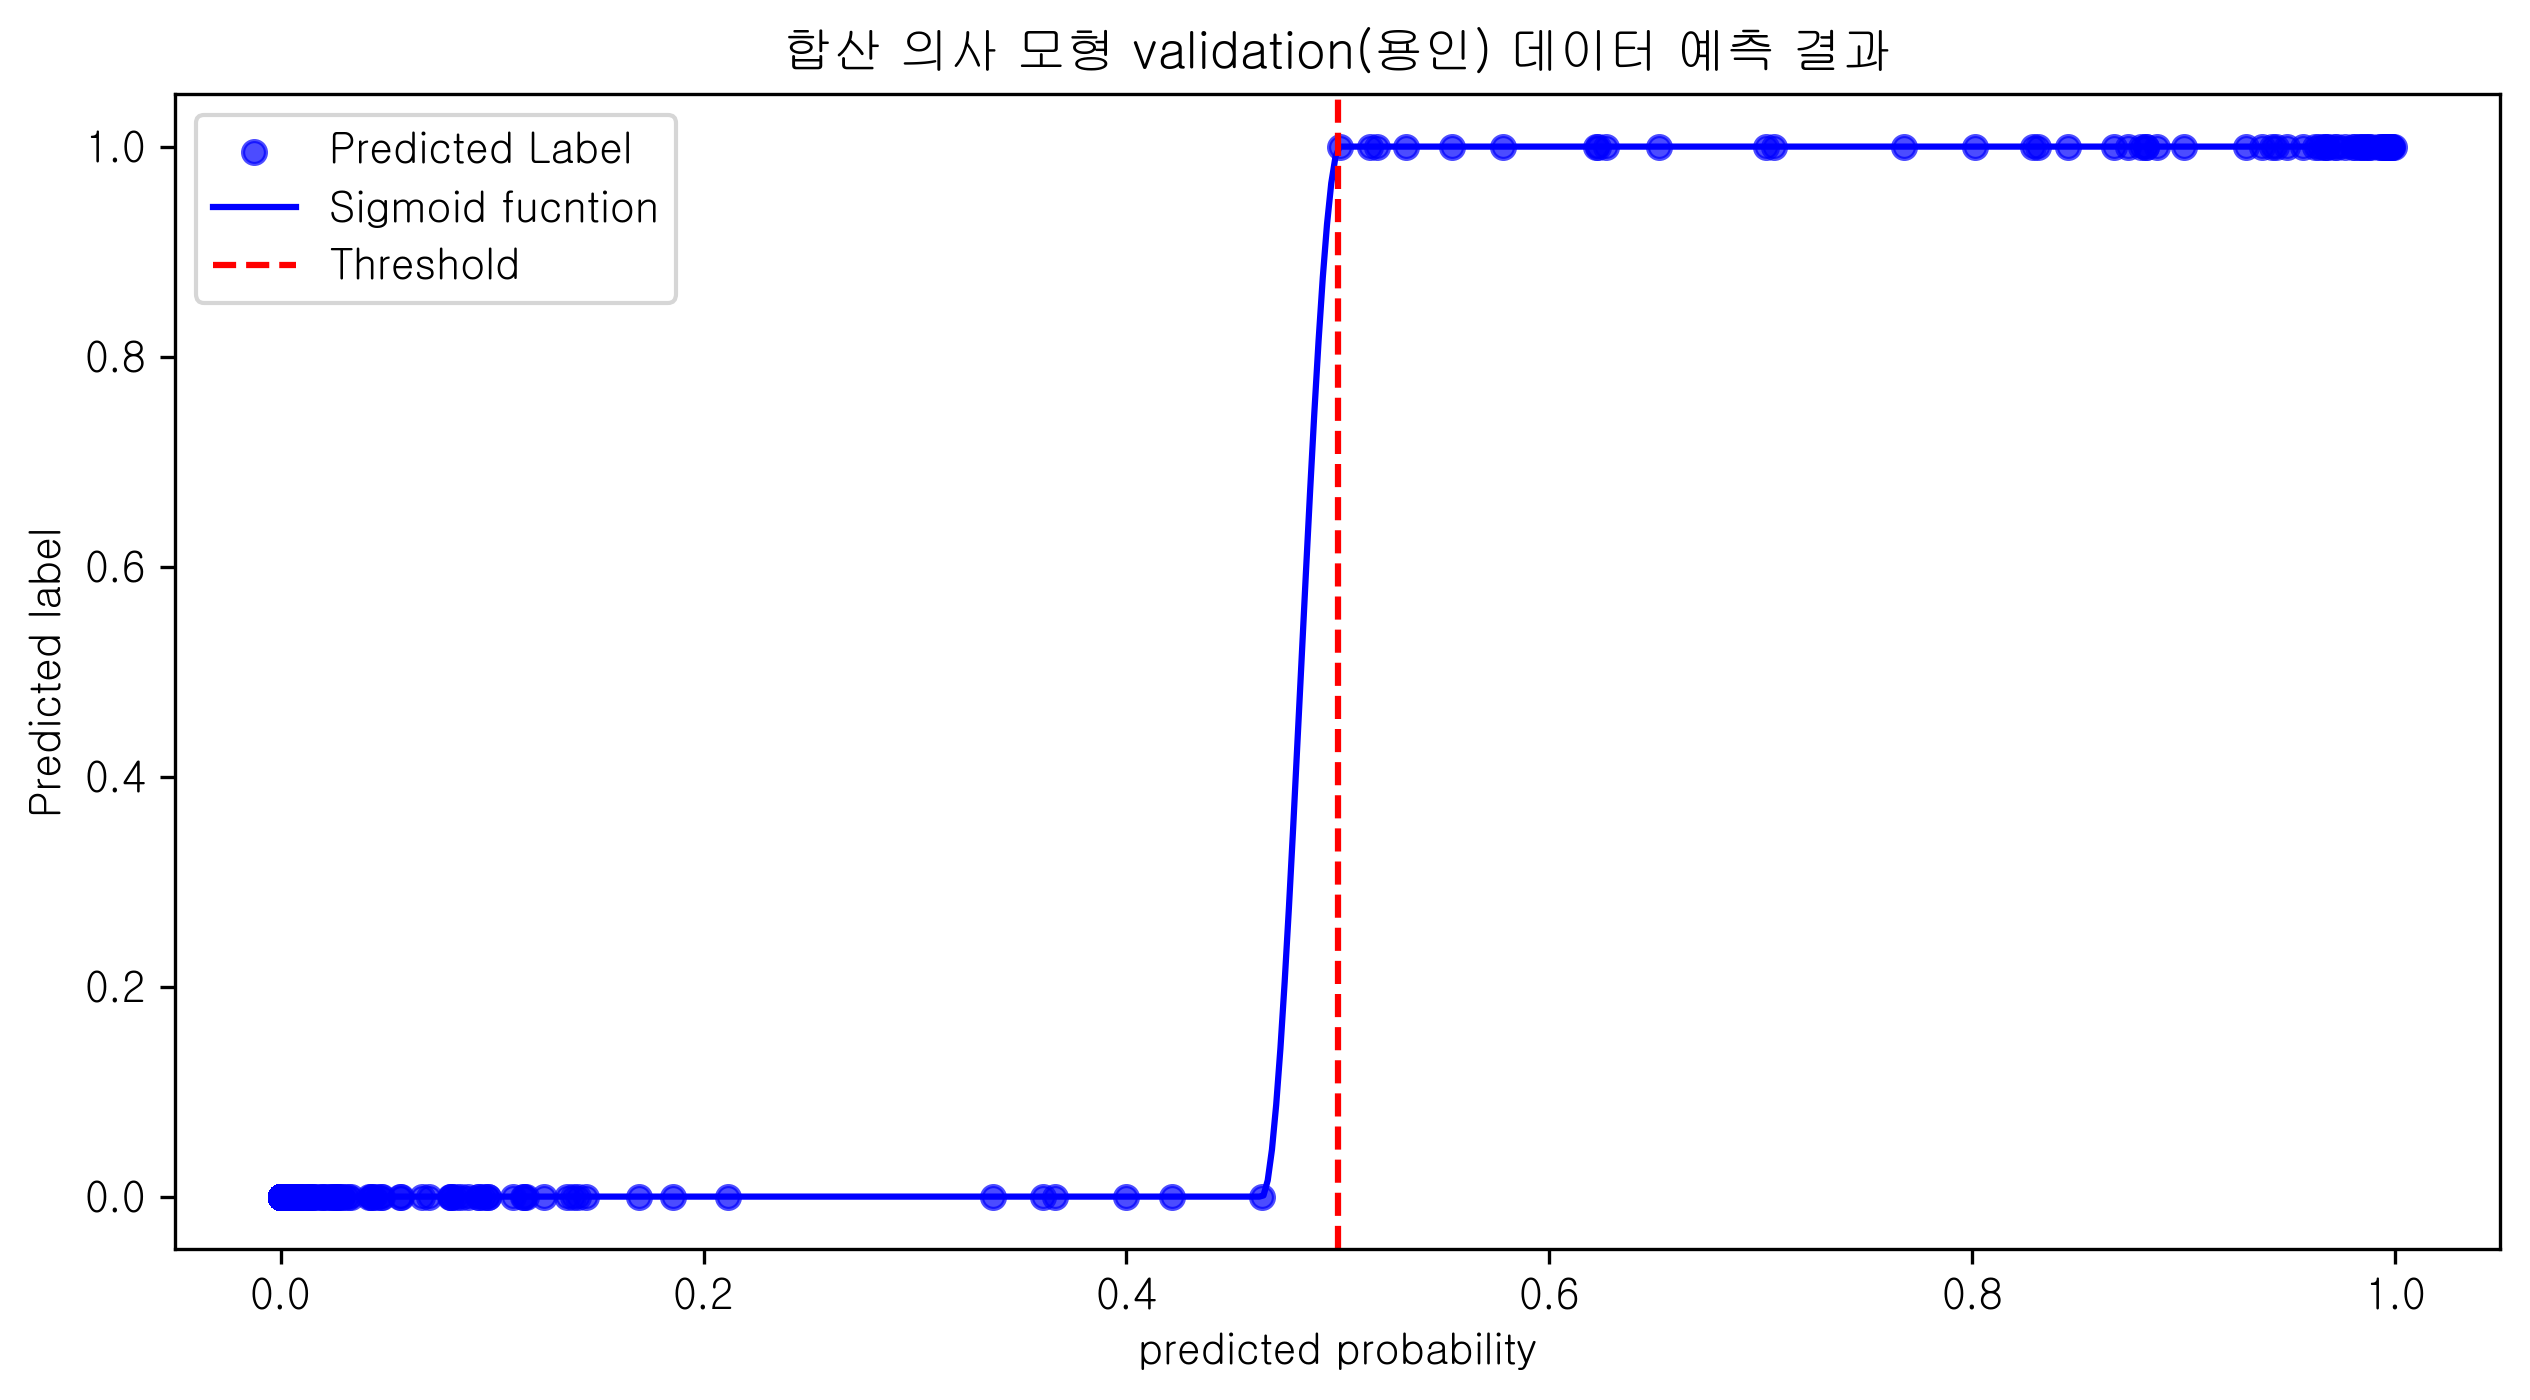

In [37]:
from scipy.interpolate import PchipInterpolator

# 데이터 포인트를 예측 확률에 따라 정렬
sorted_indices = np.argsort(test_pred_prob[:,1])
sorted_ex_copy_pred_prob = test_pred_prob[:,1][sorted_indices]
sorted_ex_copy_pred = test_pred[sorted_indices]

# PchipInterpolator를 사용하여 보간 객체 생성
f = PchipInterpolator(sorted_ex_copy_pred_prob, sorted_ex_copy_pred)

# 보간 함수를 사용하여 곡선 생성을 위한 y 값 계산
x_new = np.linspace(min(sorted_ex_copy_pred_prob), max(sorted_ex_copy_pred_prob), 500)
y_smooth = f(x_new)

# 그래프 그리기
plt.figure(figsize=(10,5), dpi=300)
plt.scatter(test_pred_prob[:,1], test_pred, color='blue', label='Predicted Label', alpha=0.7, s=30)
plt.plot(x_new, y_smooth, color='blue', label='Sigmoid fucntion')

# 기타 그래프 설정
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')
plt.xlabel('predicted probability')
plt.ylabel('Predicted label')
plt.title('합산 의사 모형 validation(용인) 데이터 예측 결과')
plt.legend()
plt.grid(False)
plt.show()

### 10% 중간 영역 제외

In [38]:
ex_copy.pred_prob.head()

0    0.464096
1    0.996576
2    0.000010
3    0.000205
4    0.000026
Name: pred_prob, dtype: float32

In [39]:
# 8개 제외됨
ex_copy_no_middle_10 = ex_copy[(ex_copy['pred_prob'] < 0.45) | (ex_copy['pred_prob'] > 0.55)].copy()
print(ex_copy_no_middle_10.shape)
ex_copy_no_middle_10.head()

(627, 20)


,age,sex,HTN,DM,plt,alb,bun,cr,eGFR,blood_dip,protein_dip,acr_urine,pcr_urine,glu,RBC,WBC,Biopsy,Biopsy_new,pred,pred_prob
1,38,1,0,0,441,4.4,14.0,1.02,92.805164,3.0,3.0,1224.4,1.8593,88,20,2,0,1,1,0.996576
2,43,1,1,1,196,4.5,9.8,0.62,121.494743,0.0,2.0,185.6,0.2984,276,2,2,0,0,0,0.000010
3,41,1,1,0,283,4.1,25.6,1.44,59.890404,0.0,0.0,8.0,0.0382,104,2,2,0,0,0,0.000205
4,62,1,0,0,186,4.4,14.2,0.65,104.269863,0.0,0.0,8.0,0.1232,90,2,2,0,0,0,0.000026
5,60,1,0,0,255,5.1,13.2,0.95,86.653354,0.0,3.0,868.3,1.3104,114,2,5,0,1,1,0.976329


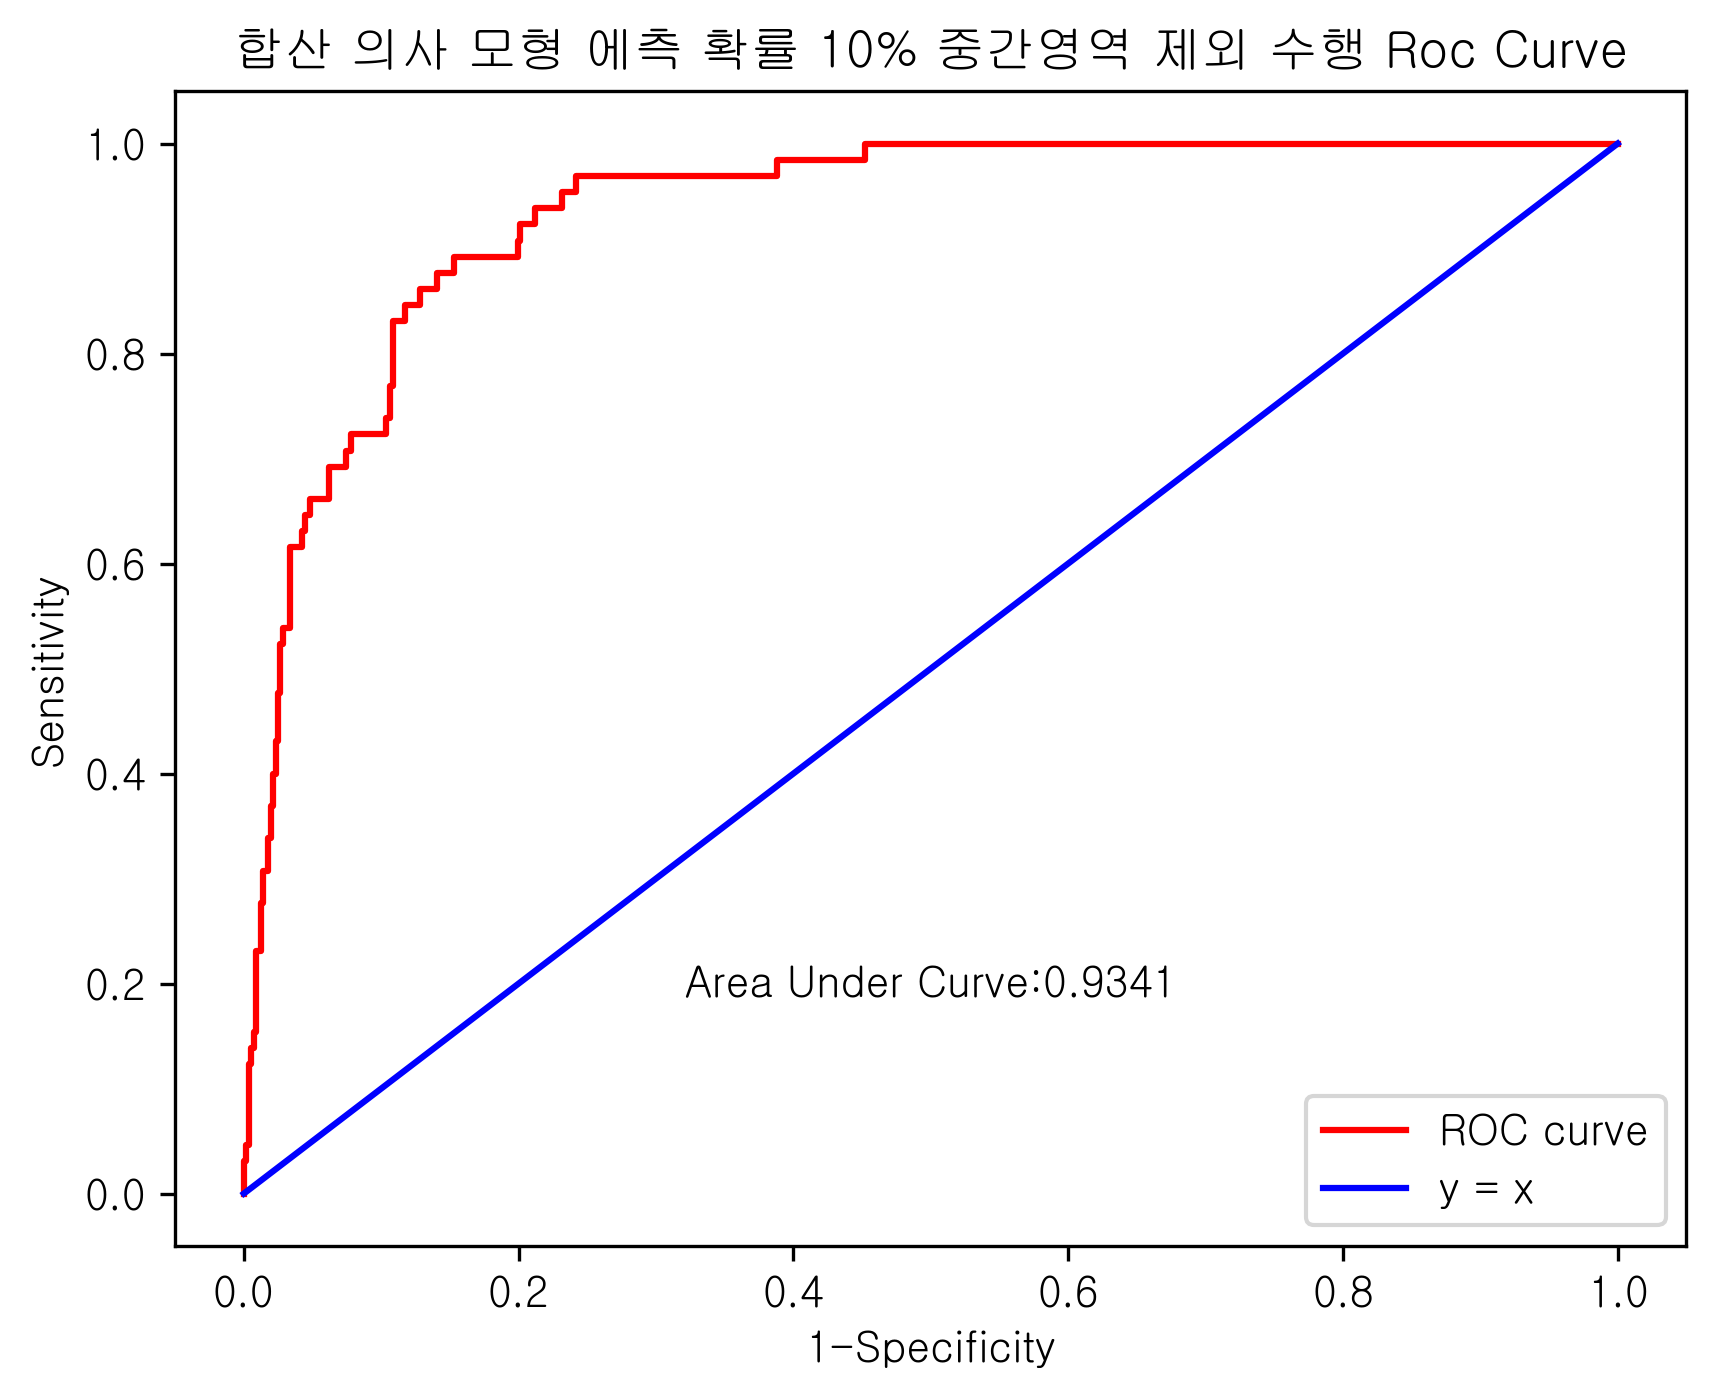

In [40]:
# roc curve, auc validation set
fpr, tpr, thresholds = roc_curve(np.array(ex_copy_no_middle_10['Biopsy']), ex_copy_no_middle_10['pred_prob'])

plt.figure(figsize=(6.5,5), dpi=300)

# auc 계산

plt.plot(fpr, tpr, color = 'red', label = 'ROC curve')
plt.plot([0, 1], [0, 1], color = 'blue', label = 'y = x') # y = x 직선 표시

auc = roc_auc_score(np.array(ex_copy_no_middle_10['Biopsy']), ex_copy_no_middle_10['pred_prob'])
plt.text(0.5, 0.2, f"Area Under Curve:{auc:.4f}", ha='center', va='center', fontsize=10)
plt.title('합산 의사 모형 에측 확률 10% 중간영역 제외 수행 Roc Curve')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')

plt.legend() # 그래프 라벨 표시

plt.show()

In [41]:
print(classification_report(ex_copy_no_middle_10['Biopsy'], ex_copy_no_middle_10['pred']))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       562
           1       0.65      0.54      0.59        65

    accuracy                           0.92       627
   macro avg       0.80      0.75      0.77       627
weighted avg       0.92      0.92      0.92       627



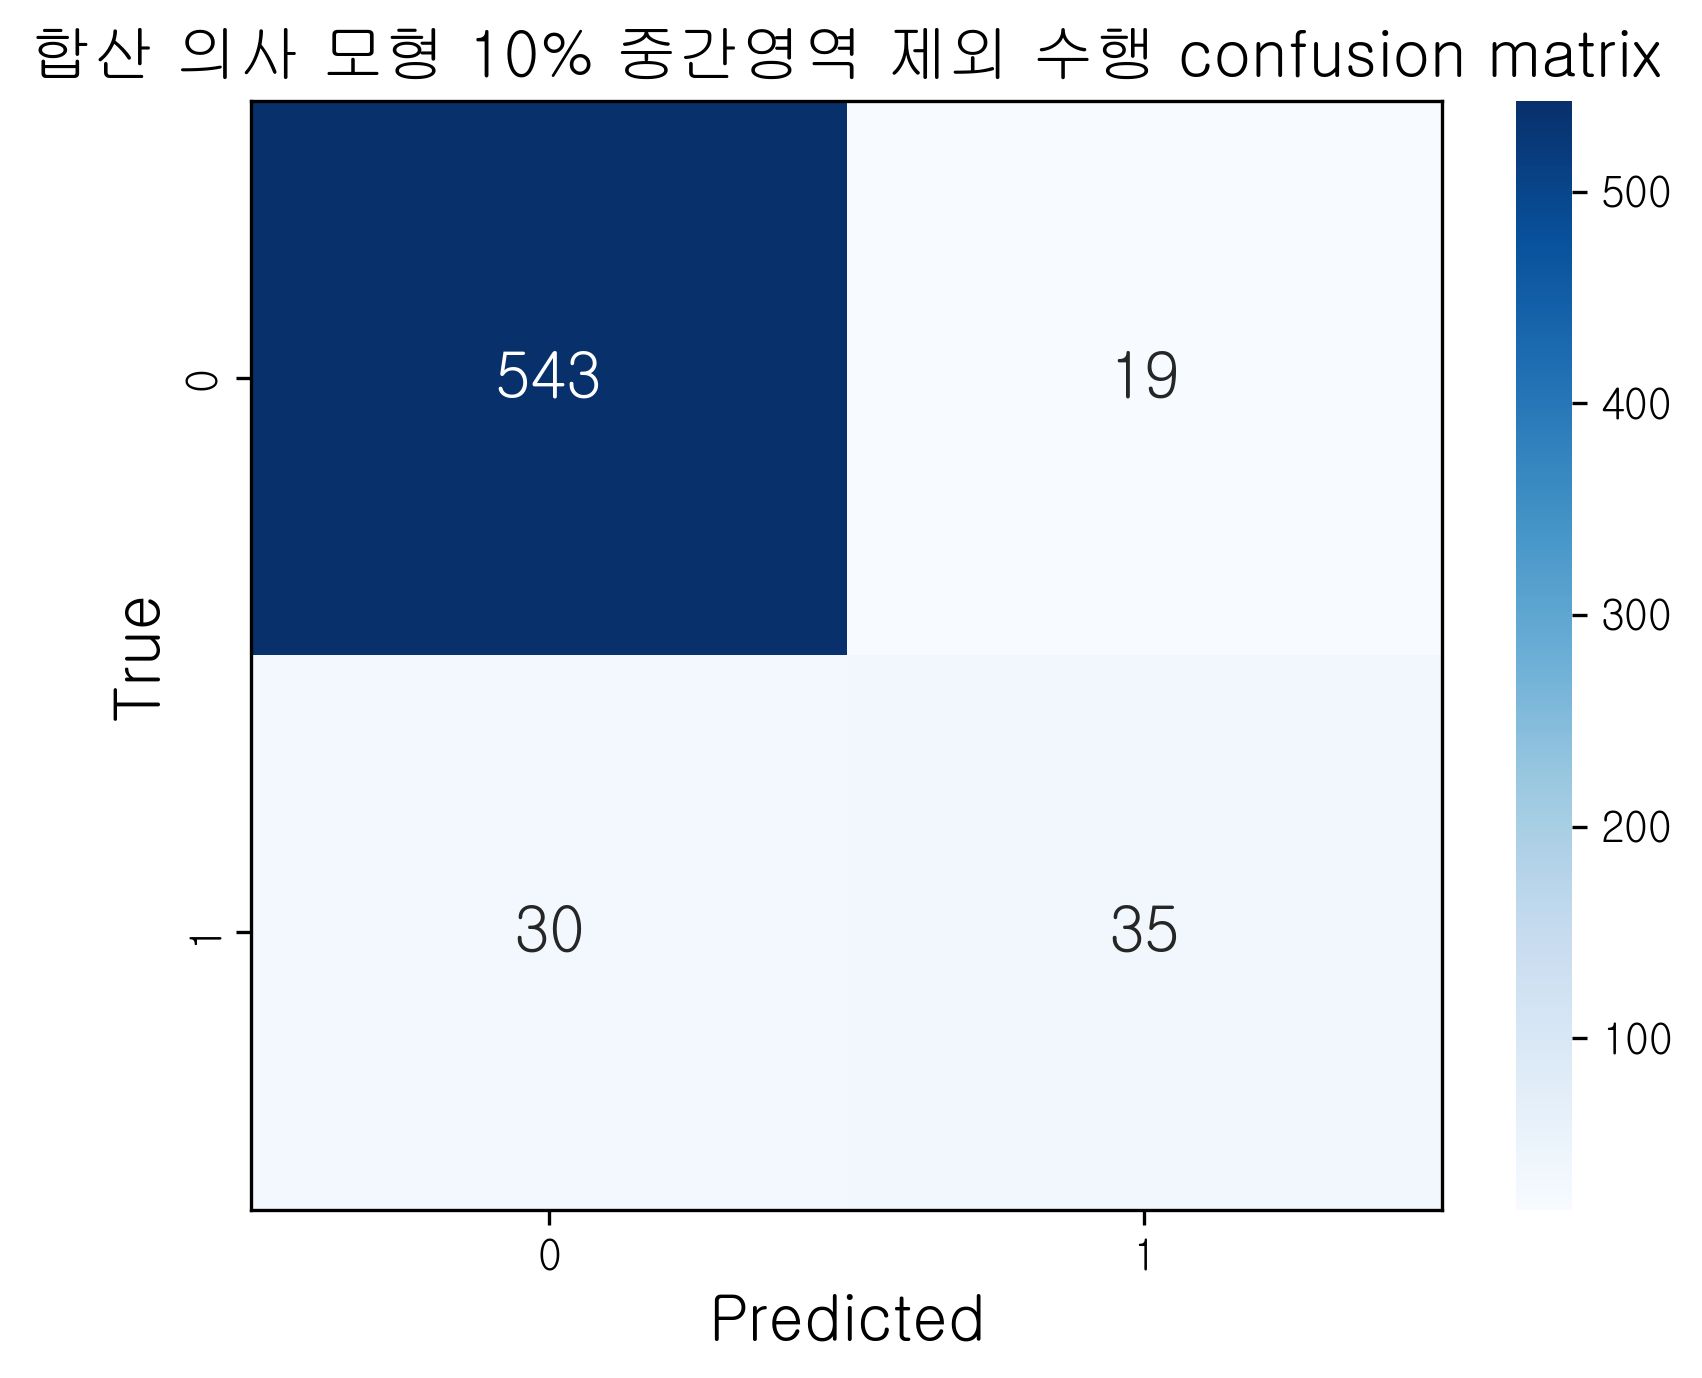

In [42]:
cm = confusion_matrix(ex_copy_no_middle_10['Biopsy'], ex_copy_no_middle_10['pred'])

plt.figure(dpi=300)
# Plot the confusion matrix with specific formatting for annotations
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Accessing the text elements of the heatmap and setting font properties
for _, spine in heatmap.spines.items():
    spine.set_visible(True)

for t in heatmap.texts:
    t.set_fontsize(15)  # Set the font size here

plt.title('합산 의사 모형 10% 중간영역 제외 수행 confusion matrix', fontsize = 15)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)
plt.show()

In [43]:
middle_10_pred_prob = np.array(ex_copy_no_middle_10['pred_prob'])
middle_10_pred = np.array(ex_copy_no_middle_10['pred'])

print(len(middle_10_pred_prob))
print(len(ex_copy_no_middle_10['pred_prob']))

627
627


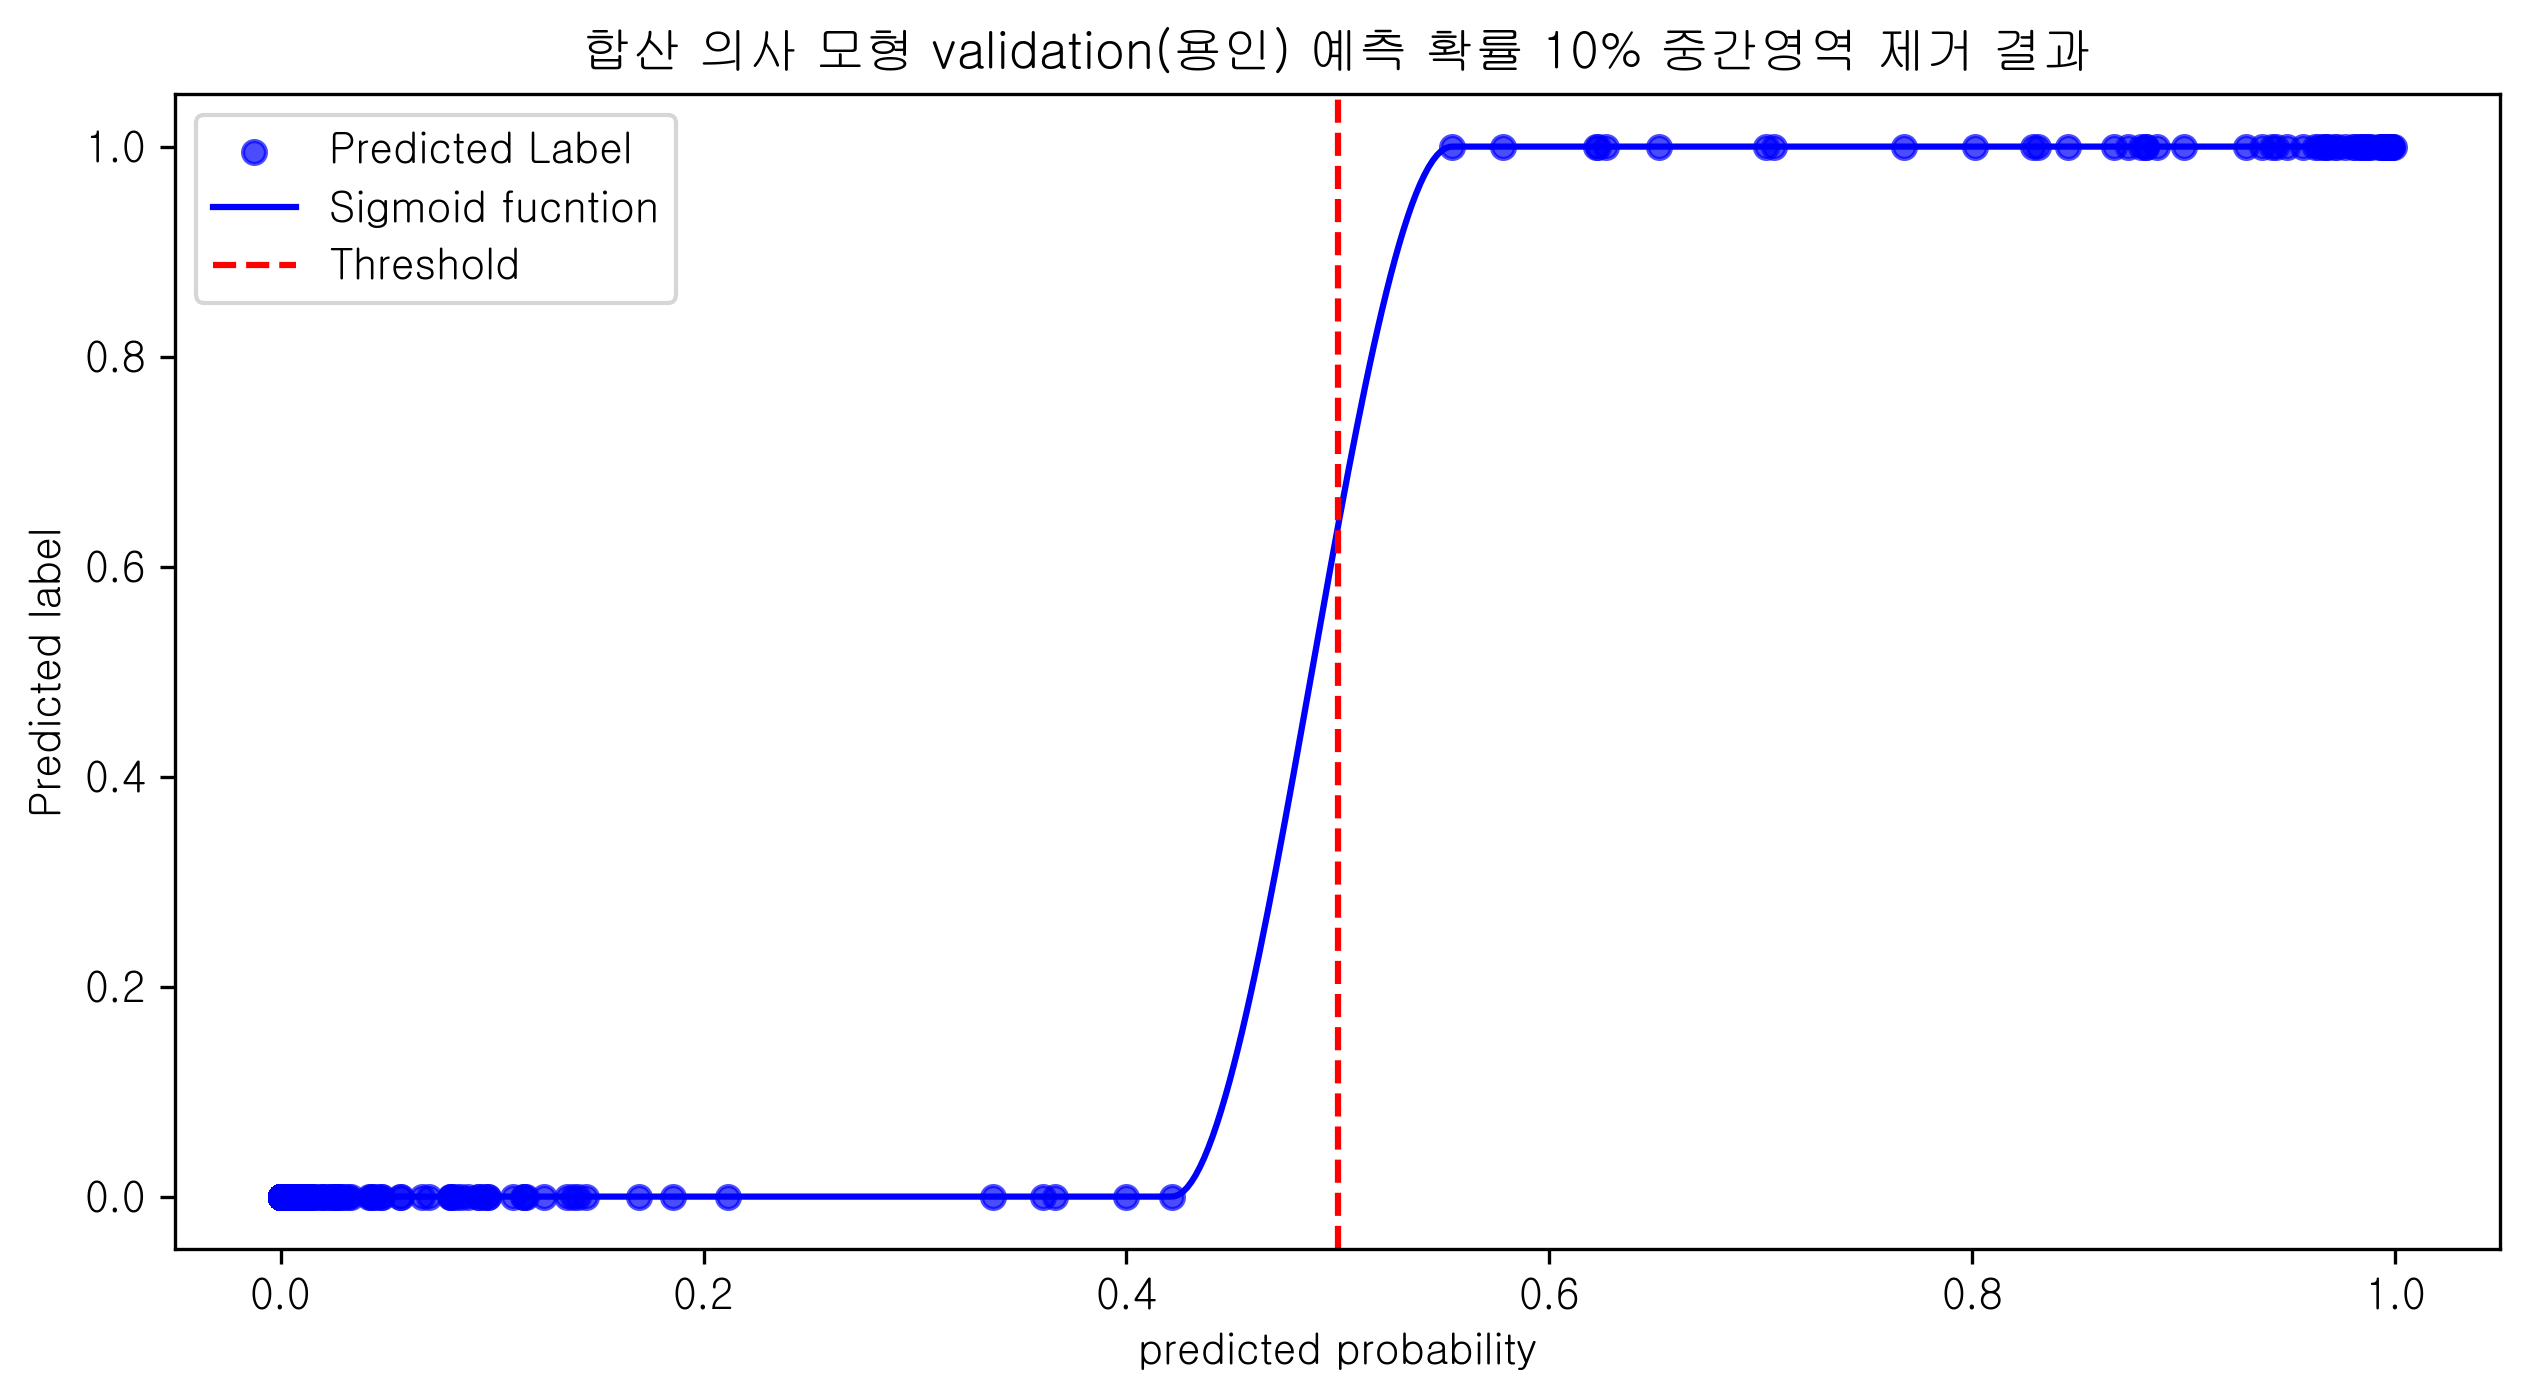

In [45]:
from scipy.interpolate import PchipInterpolator

# 데이터 포인트를 예측 확률에 따라 정렬
sorted_indices = np.argsort(middle_10_pred_prob)
sorted_ex_copy_pred_prob = middle_10_pred_prob[sorted_indices]
sorted_ex_copy_pred = middle_10_pred[sorted_indices]

# PchipInterpolator를 사용하여 보간 객체 생성
f = PchipInterpolator(sorted_ex_copy_pred_prob, sorted_ex_copy_pred)

# 보간 함수를 사용하여 곡선 생성을 위한 y 값 계산
x_new = np.linspace(min(sorted_ex_copy_pred_prob), max(sorted_ex_copy_pred_prob), 500)
y_smooth = f(x_new)

# 그래프 그리기
plt.figure(figsize=(10,5), dpi=300)
plt.scatter(middle_10_pred_prob, middle_10_pred, color='blue', label='Predicted Label', alpha=0.7, s=30)
plt.plot(x_new, y_smooth, color='blue', label='Sigmoid fucntion')

# 기타 그래프 설정
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')
plt.xlabel('predicted probability')
plt.ylabel('Predicted label')
plt.title('합산 의사 모형 validation(용인) 예측 확률 10% 중간영역 제거 결과')
plt.legend()
plt.grid(False)
plt.show()

### 20% 중간 영역 제외

In [47]:
# 8개 제외됨
ex_copy_no_middle = ex_copy[(ex_copy['pred_prob'] < 0.4) | (ex_copy['pred_prob'] > 0.6)].copy()
print(ex_copy_no_middle.shape)
ex_copy_no_middle.head()

(624, 20)


,age,sex,HTN,DM,plt,alb,bun,cr,eGFR,blood_dip,protein_dip,acr_urine,pcr_urine,glu,RBC,WBC,Biopsy,Biopsy_new,pred,pred_prob
1,38,1,0,0,441,4.4,14.0,1.02,92.805164,3.0,3.0,1224.4,1.8593,88,20,2,0,1,1,0.996576
2,43,1,1,1,196,4.5,9.8,0.62,121.494743,0.0,2.0,185.6,0.2984,276,2,2,0,0,0,0.000010
3,41,1,1,0,283,4.1,25.6,1.44,59.890404,0.0,0.0,8.0,0.0382,104,2,2,0,0,0,0.000205
4,62,1,0,0,186,4.4,14.2,0.65,104.269863,0.0,0.0,8.0,0.1232,90,2,2,0,0,0,0.000026
5,60,1,0,0,255,5.1,13.2,0.95,86.653354,0.0,3.0,868.3,1.3104,114,2,5,0,1,1,0.976329


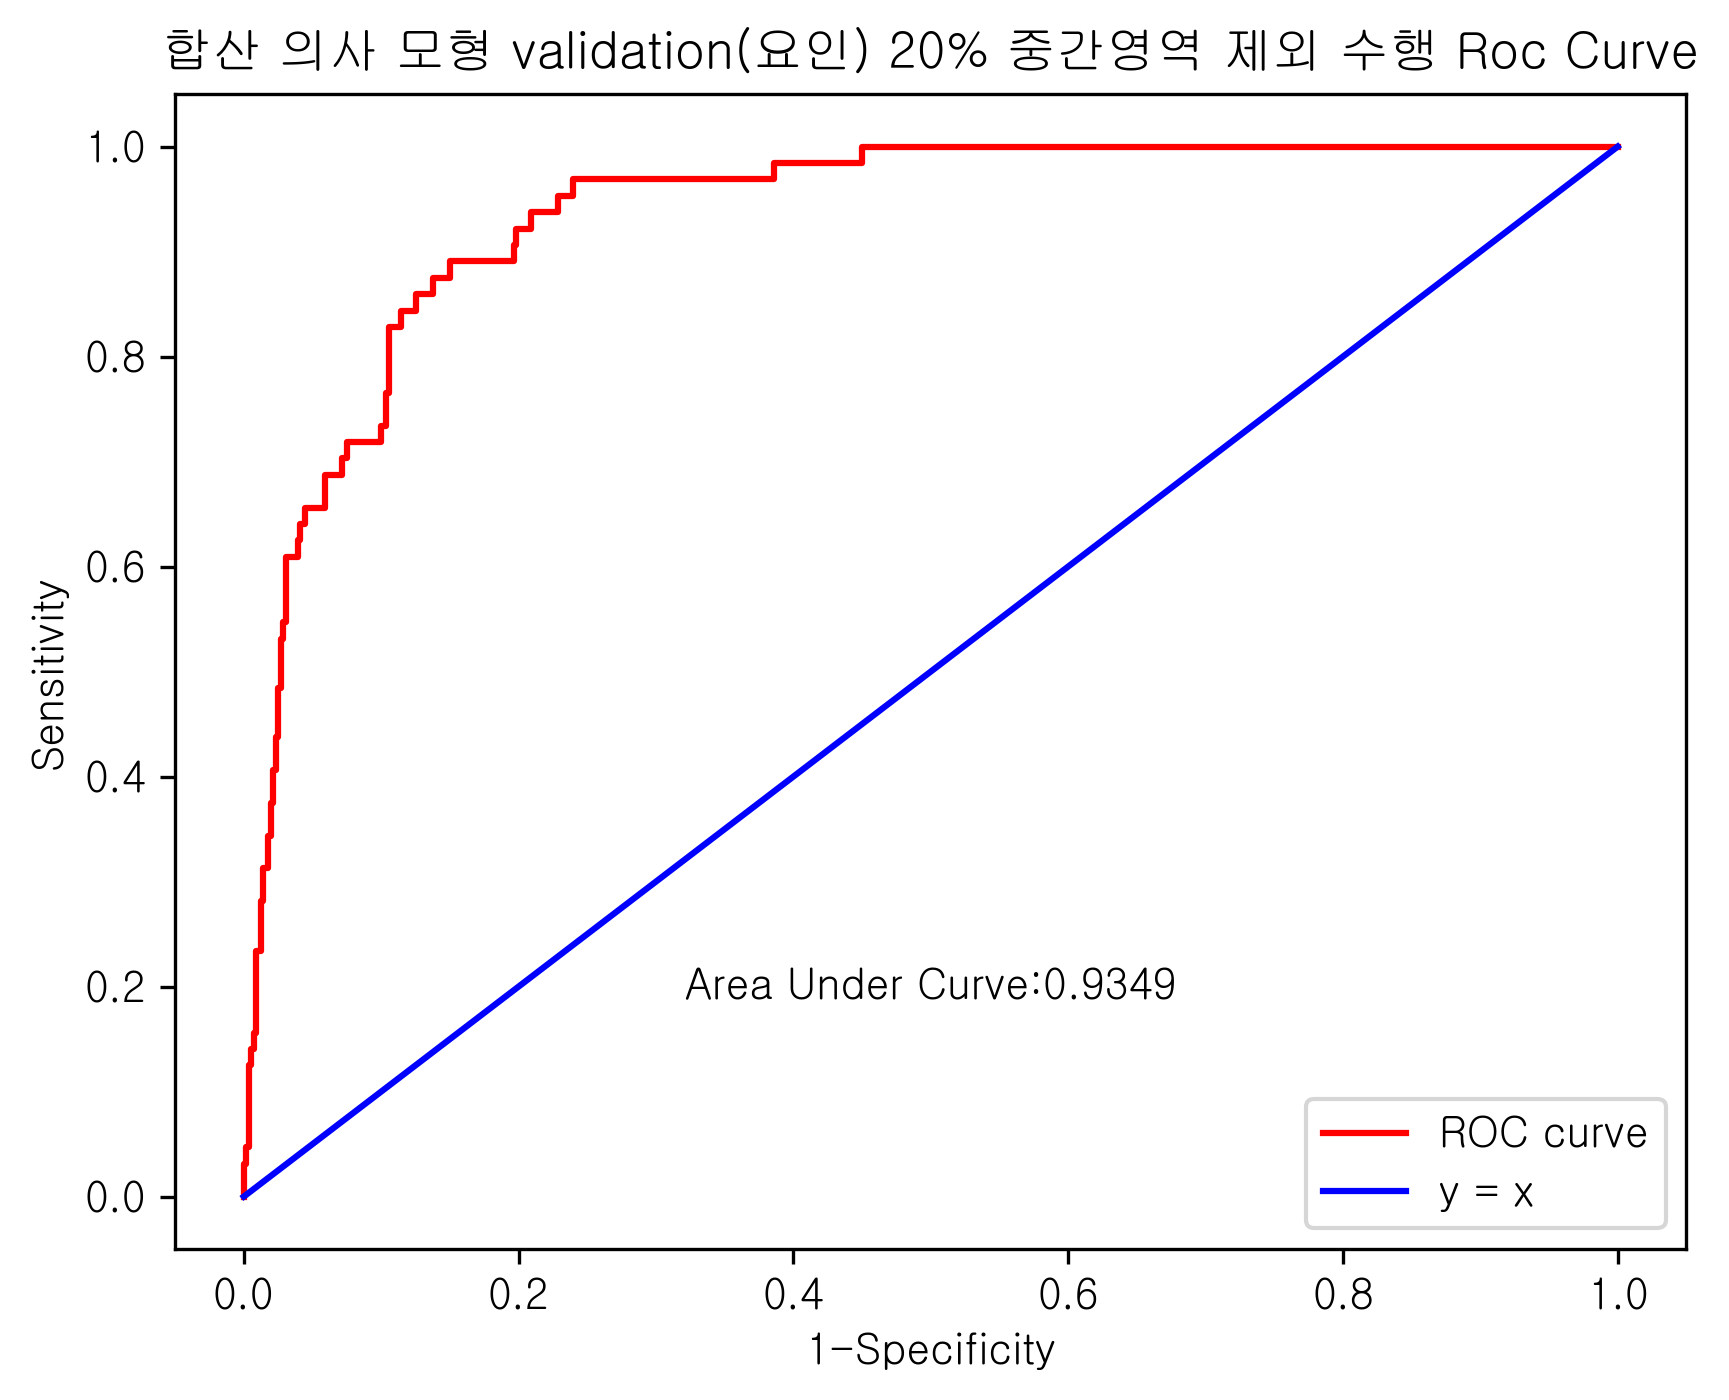

In [49]:
# roc curve, auc validation set
fpr, tpr, thresholds = roc_curve(np.array(ex_copy_no_middle['Biopsy']), ex_copy_no_middle['pred_prob'])

plt.figure(figsize=(6.5,5), dpi=300)

# auc 계산
plt.plot(fpr, tpr, color = 'red', label = 'ROC curve')
plt.plot([0, 1], [0, 1], color = 'blue', label = 'y = x') # y = x 직선 표시

auc = roc_auc_score(np.array(ex_copy_no_middle['Biopsy']), ex_copy_no_middle['pred_prob'])
plt.text(0.5, 0.2, f"Area Under Curve:{auc:.4f}", ha='center', va='center', fontsize=10)
plt.title('합산 의사 모형 validation(요인) 20% 중간영역 제외 수행 Roc Curve')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')

plt.legend() # 그래프 라벨 표시

plt.show()

In [50]:
print(classification_report(ex_copy_no_middle['Biopsy'], ex_copy_no_middle['pred']))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       560
           1       0.67      0.55      0.60        64

    accuracy                           0.93       624
   macro avg       0.81      0.76      0.78       624
weighted avg       0.92      0.93      0.92       624



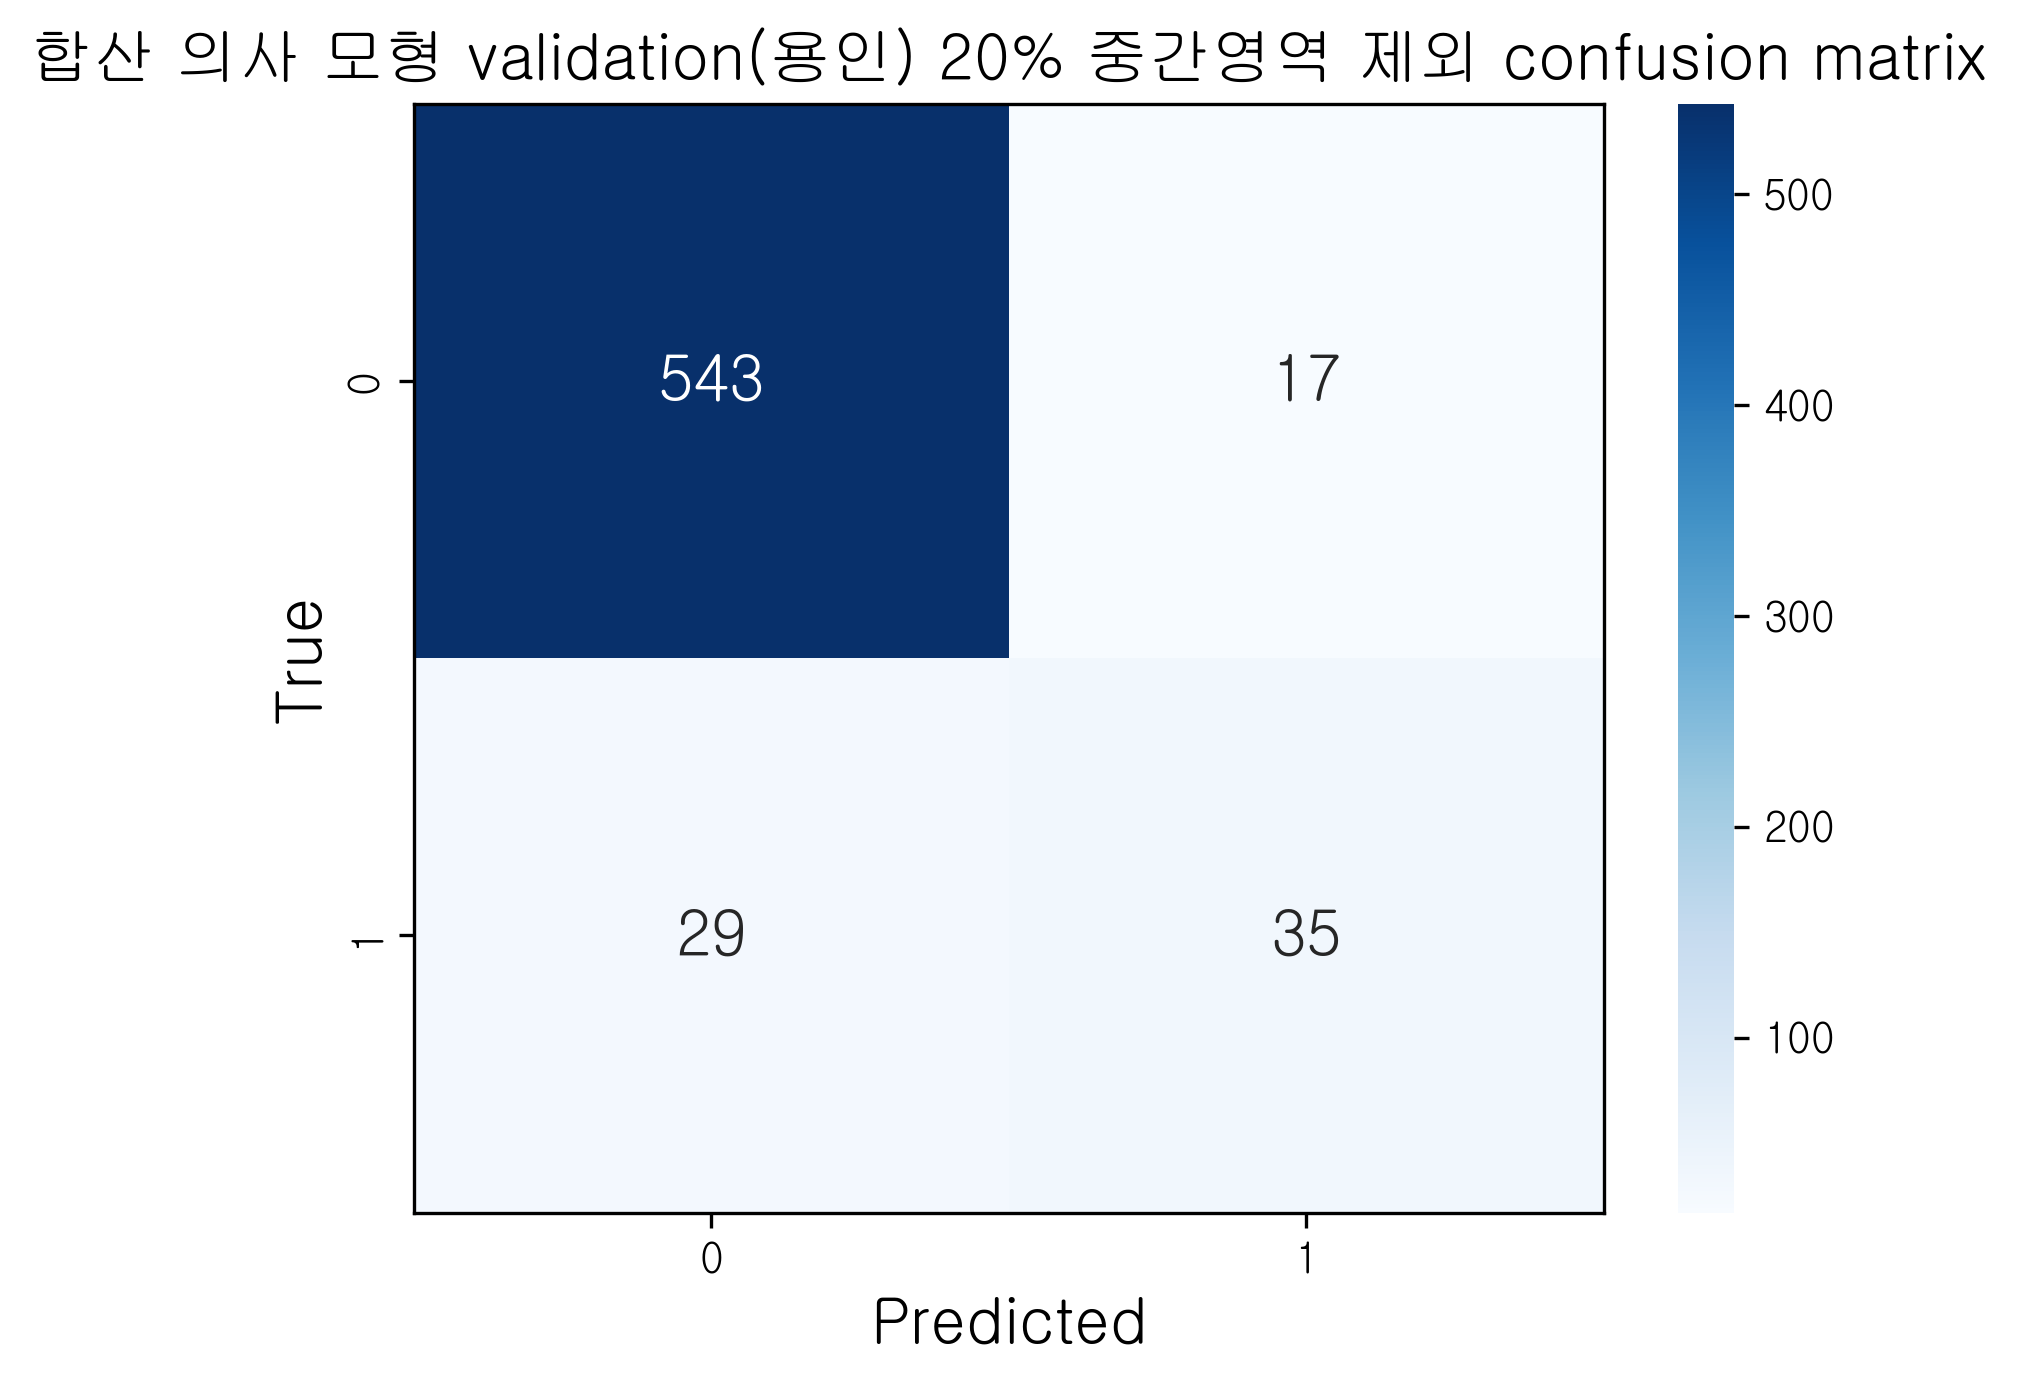

In [53]:
cm = confusion_matrix(ex_copy_no_middle['Biopsy'], ex_copy_no_middle['pred'])

plt.figure(dpi=300)
# Plot the confusion matrix with specific formatting for annotations
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Accessing the text elements of the heatmap and setting font properties
for _, spine in heatmap.spines.items():
    spine.set_visible(True)

for t in heatmap.texts:
    t.set_fontsize(15)  # Set the font size here

plt.title('합산 의사 모형 validation(용인) 20% 중간영역 제외 confusion matrix', fontsize = 15)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)
plt.show()

In [54]:
middle_pred_prob = np.array(ex_copy_no_middle['pred_prob'])
middle_pred = np.array(ex_copy_no_middle['pred'])

print(len(middle_pred_prob))
print(len(ex_copy_no_middle['pred_prob']))

624
624


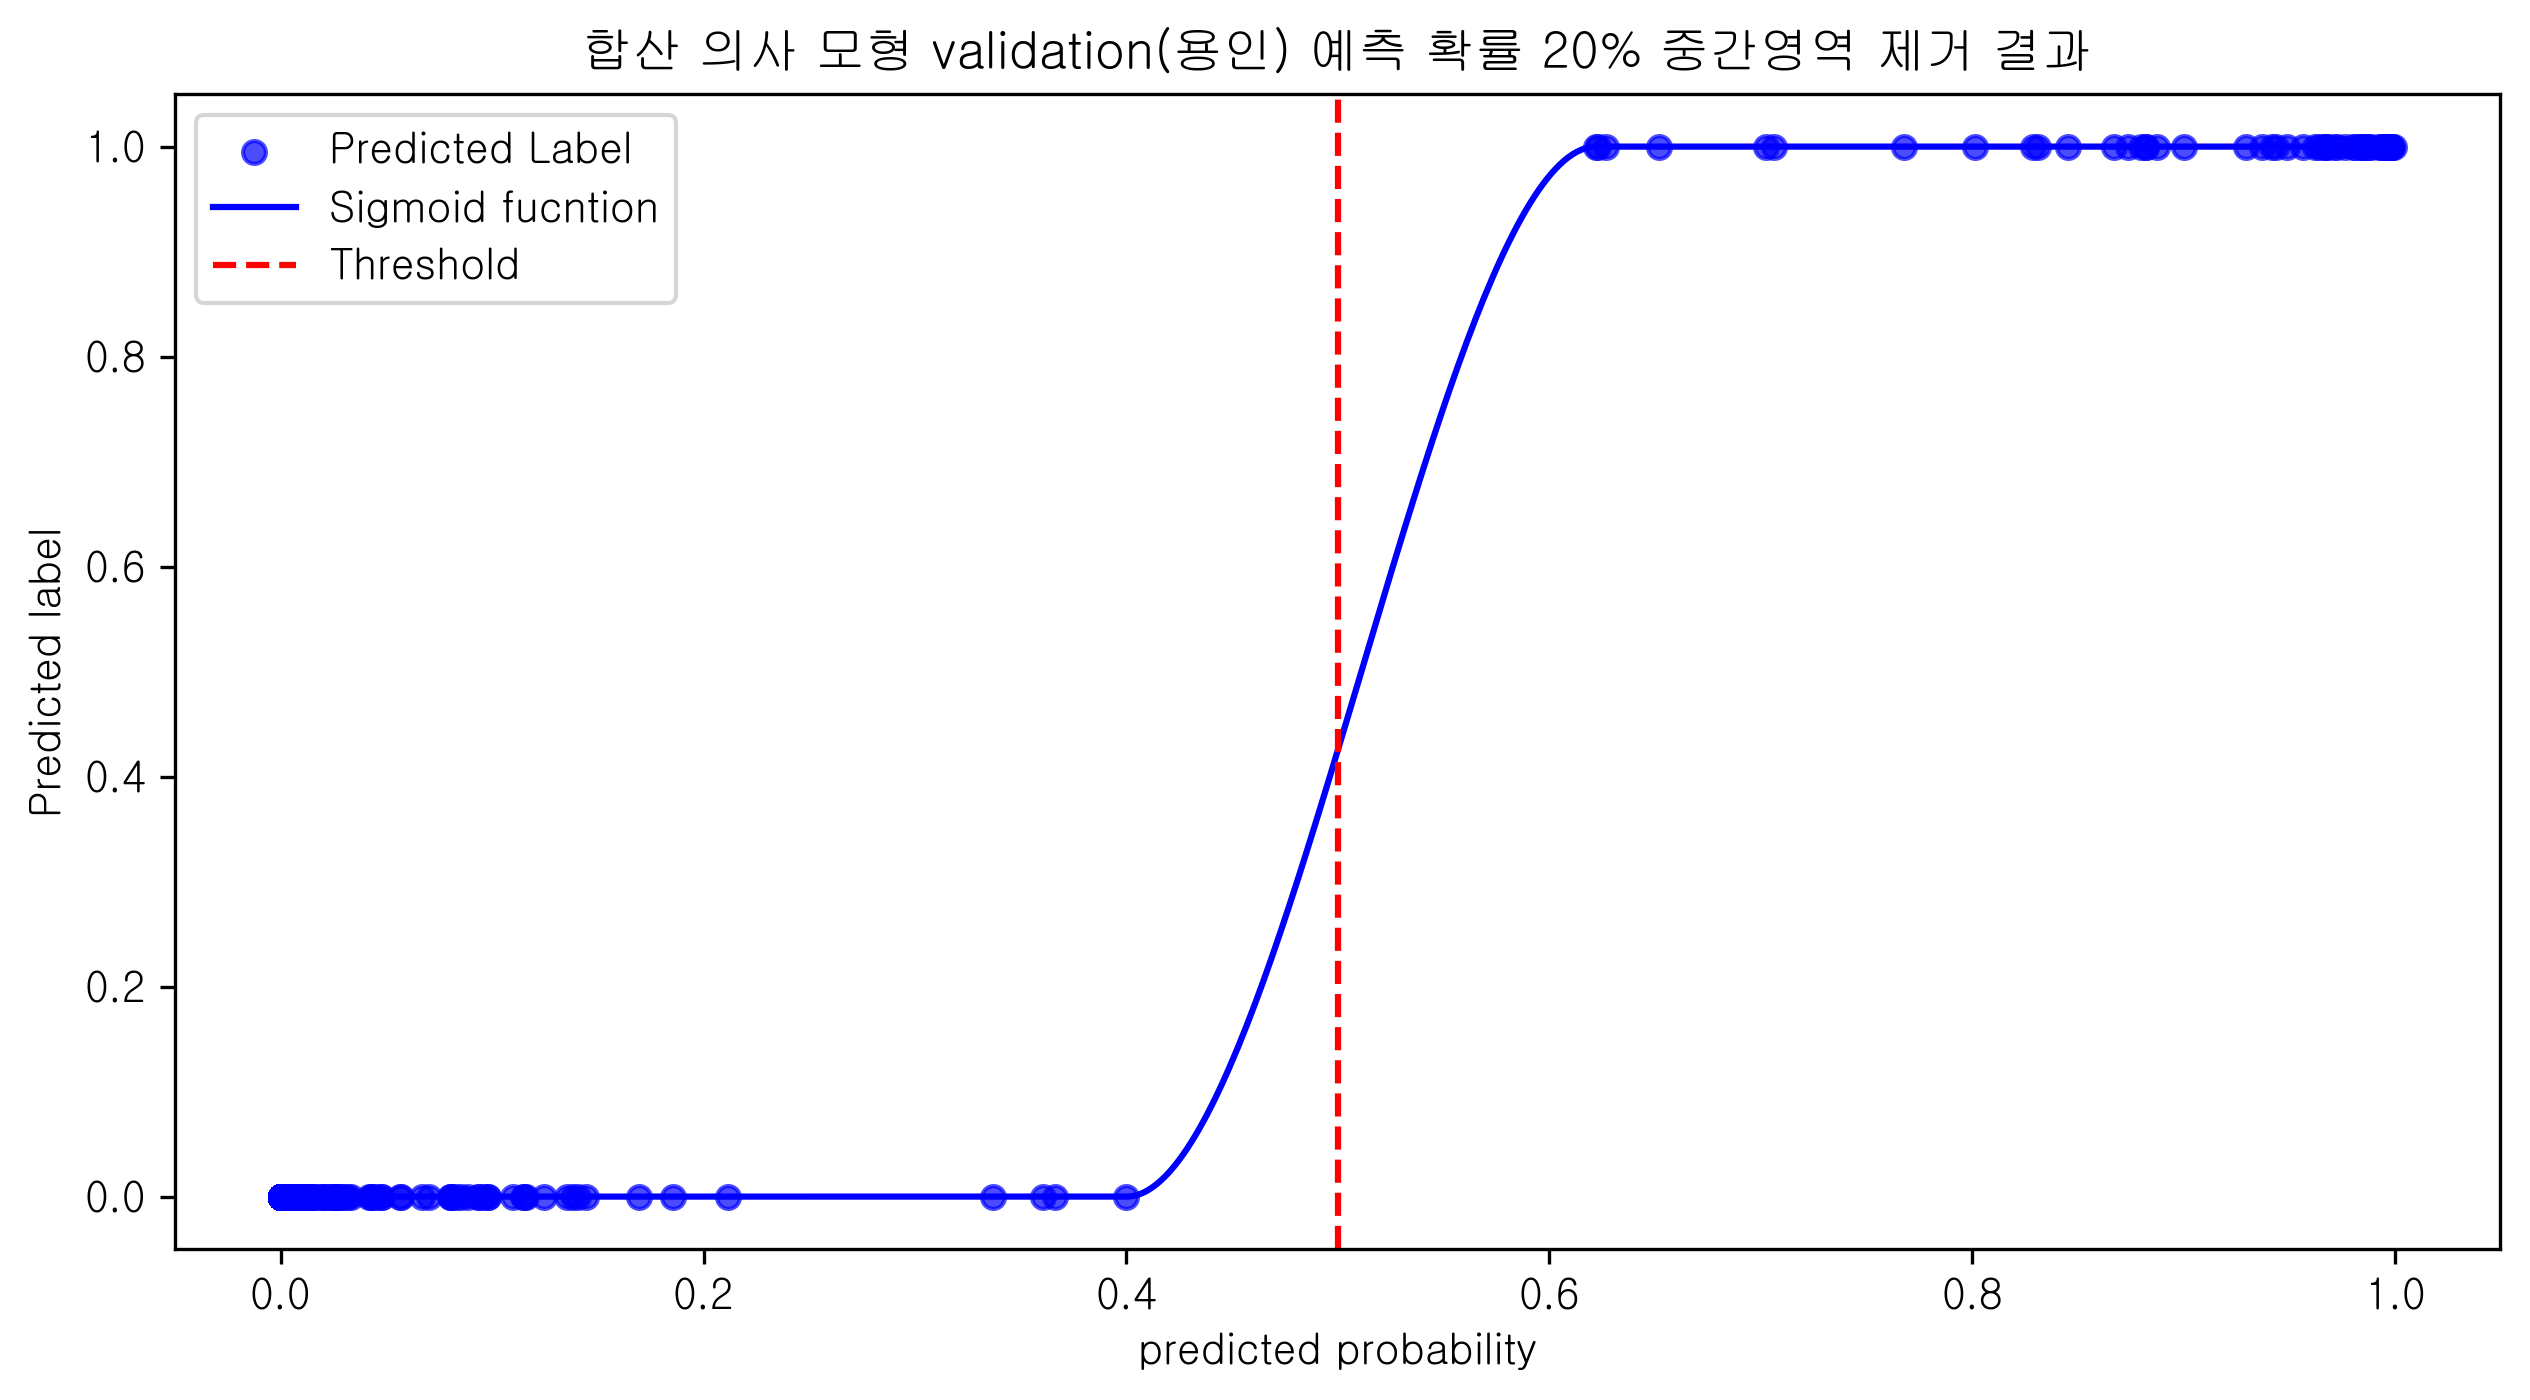

In [56]:
from scipy.interpolate import PchipInterpolator

# 데이터 포인트를 예측 확률에 따라 정렬
sorted_indices = np.argsort(middle_pred_prob)
sorted_ex_copy_pred_prob = middle_pred_prob[sorted_indices]
sorted_ex_copy_pred = middle_pred[sorted_indices]

# PchipInterpolator를 사용하여 보간 객체 생성
f = PchipInterpolator(sorted_ex_copy_pred_prob, sorted_ex_copy_pred)

# 보간 함수를 사용하여 곡선 생성을 위한 y 값 계산
x_new = np.linspace(min(sorted_ex_copy_pred_prob), max(sorted_ex_copy_pred_prob), 500)
y_smooth = f(x_new)

# 그래프 그리기
plt.figure(figsize=(10,5), dpi=300)
plt.scatter(middle_pred_prob, middle_pred, color='blue', label='Predicted Label', alpha=0.7, s=30)
plt.plot(x_new, y_smooth, color='blue', label='Sigmoid fucntion')

# 기타 그래프 설정
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')
plt.xlabel('predicted probability')
plt.ylabel('Predicted label')
plt.title('합산 의사 모형 validation(용인) 예측 확률 20% 중간영역 제거 결과')
plt.legend()
plt.grid(False)
plt.show()

## Modeling_Biopsy_new

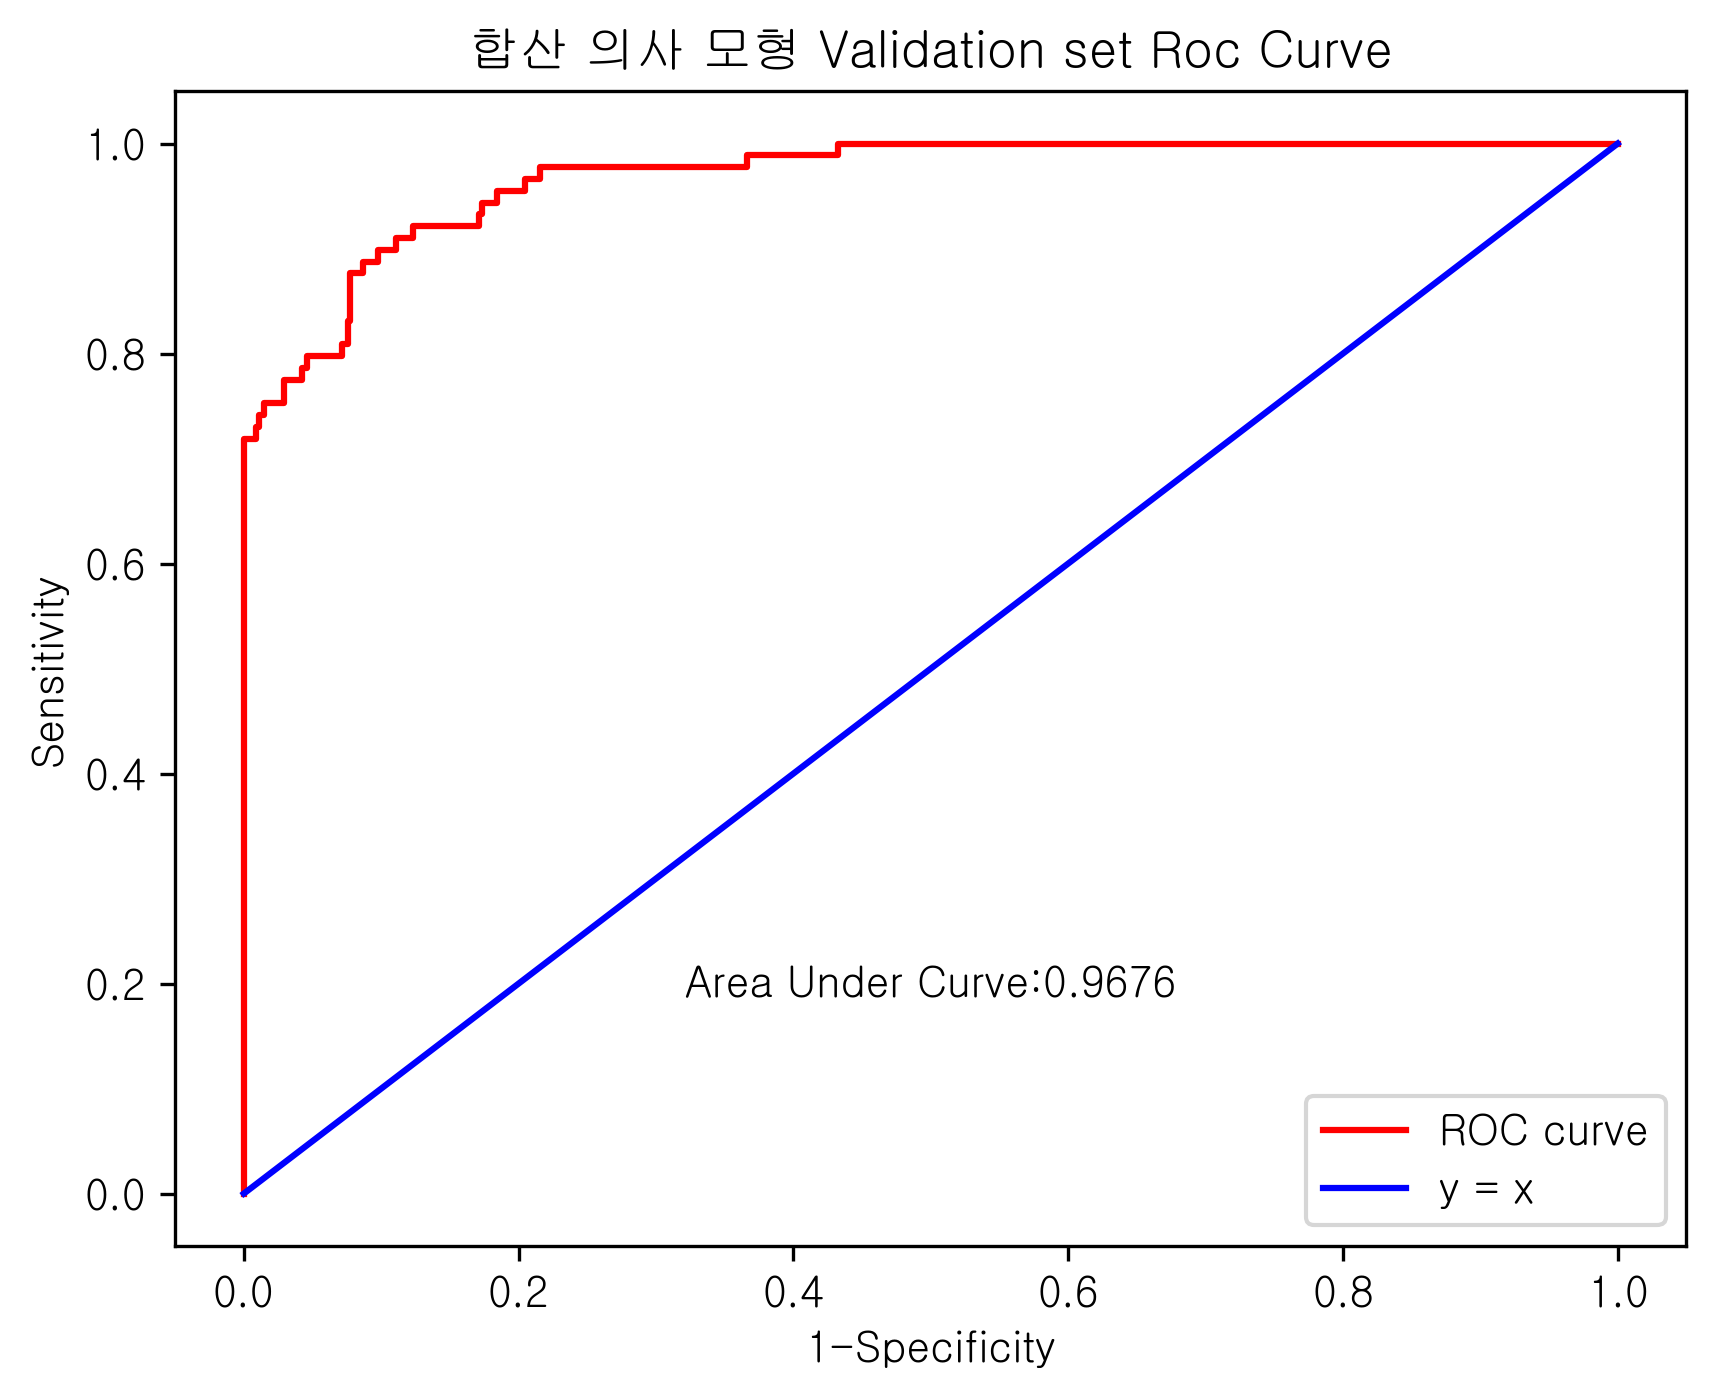

In [57]:
# roc curve, auc validation set
fpr, tpr, thresholds = roc_curve(np.array(ex_copy['Biopsy_new']), test_pred_prob[:,1])

plt.figure(figsize=(6.5, 5), dpi=300)
plt.plot(fpr, tpr, color = 'red', label = 'ROC curve')
plt.plot([0, 1], [0, 1], color = 'blue', label = 'y = x') # y = x 직선 표시

auc = roc_auc_score(np.array(ex_copy['Biopsy_new']), test_pred_prob[:,1])
plt.text(0.5, 0.2, f"Area Under Curve:{auc:.4f}", ha='center', va='center', fontsize=10)

plt.title('합산 의사 모형 Validation set Roc Curve')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.legend() # 그래프 라벨 표시

plt.show()

In [58]:
print(classification_report(ex_copy['Biopsy_new'], test_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       543
           1       1.00      0.65      0.79        89

    accuracy                           0.95       632
   macro avg       0.97      0.83      0.88       632
weighted avg       0.95      0.95      0.95       632



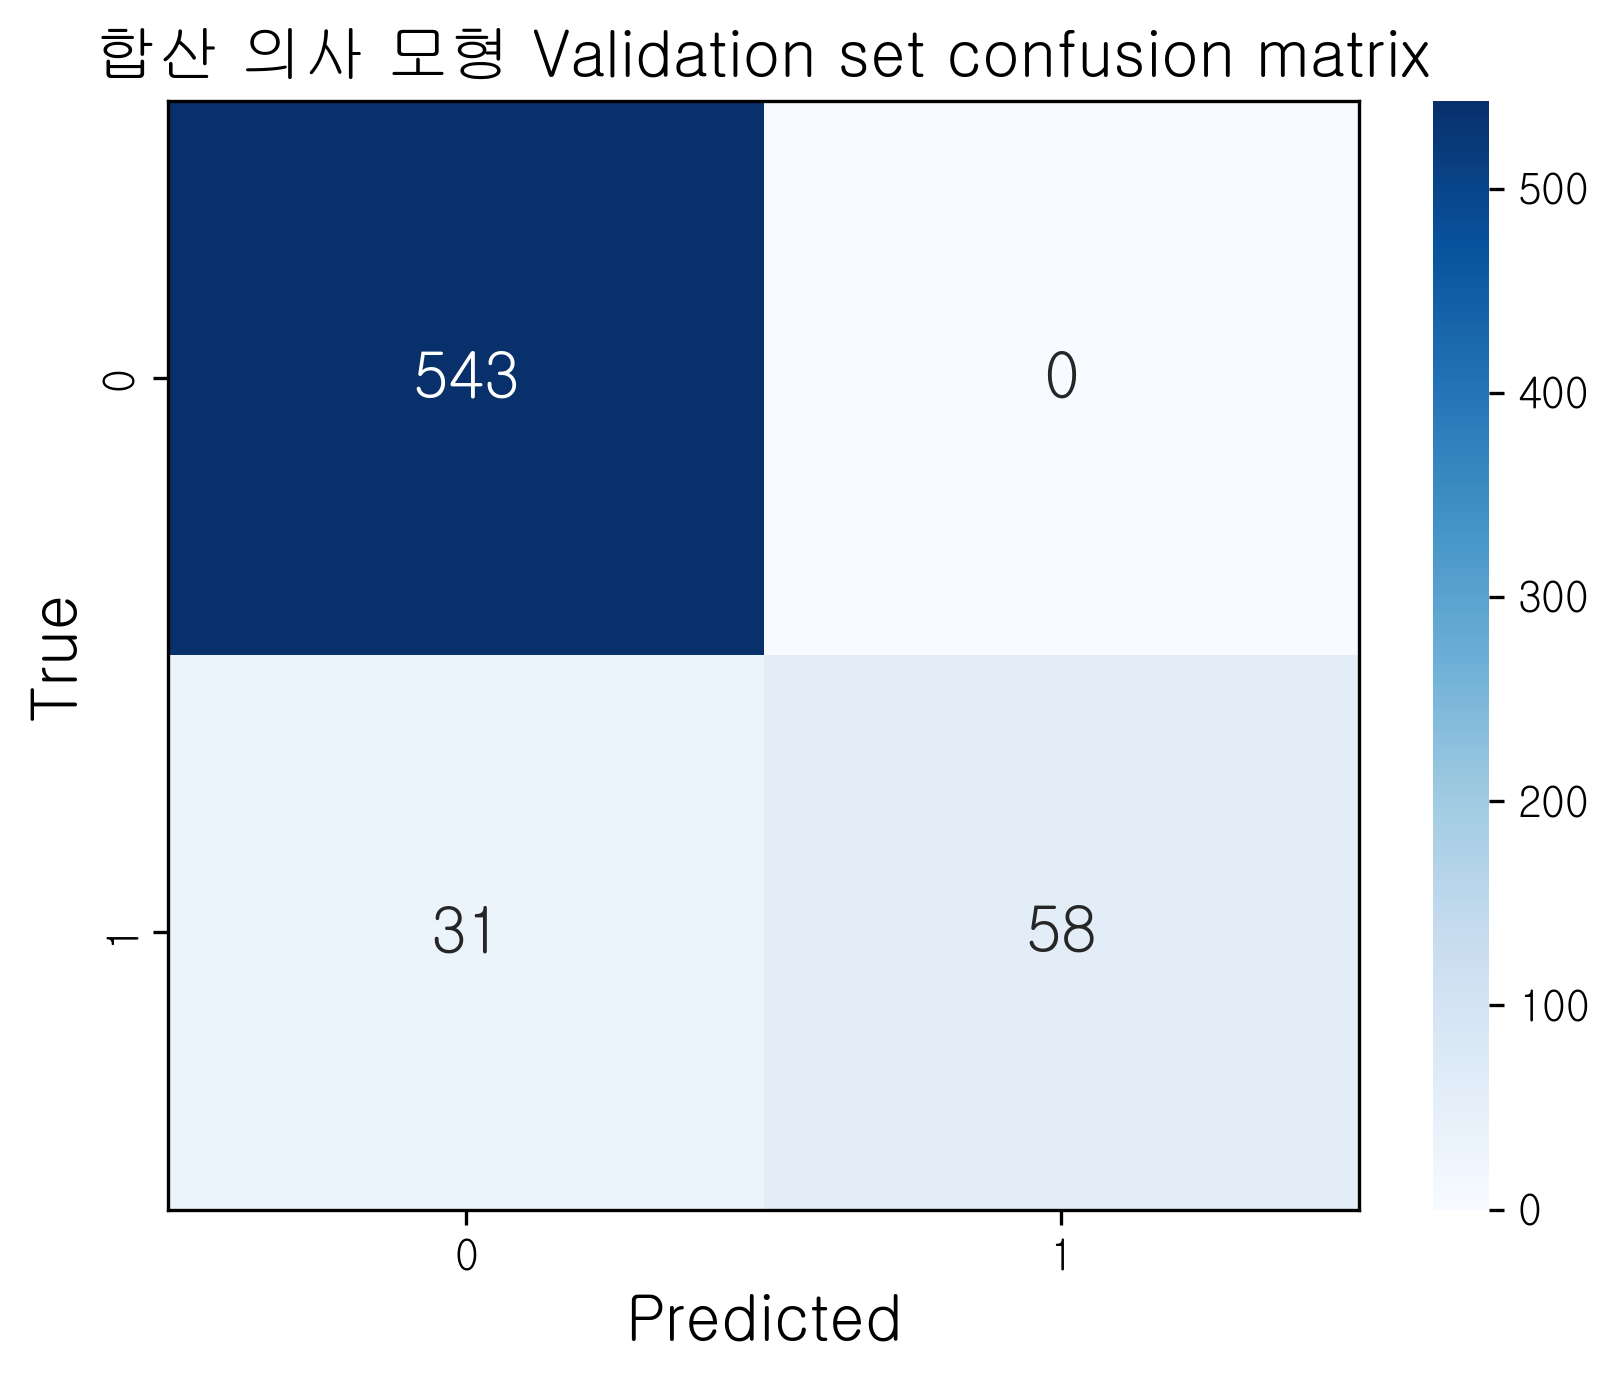

In [59]:
cm = confusion_matrix(ex_copy['Biopsy_new'], test_pred)

plt.figure(dpi=300)
# Plot the confusion matrix with specific formatting for annotations
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Accessing the text elements of the heatmap and setting font properties
for _, spine in heatmap.spines.items():
    spine.set_visible(True)

for t in heatmap.texts:
    t.set_fontsize(15)  # Set the font size here

plt.title('합산 의사 모형 Validation set confusion matrix', fontsize = 15)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)
plt.show()

### 10% 중간 영역 제외

In [60]:
# 8개 제외됨
ex_copy_no_middle_10 = ex_copy[(ex_copy['pred_prob'] < 0.45) | (ex_copy['pred_prob'] > 0.55)].copy()
print(ex_copy_no_middle_10.shape)
ex_copy_no_middle_10.head()

(627, 20)


,age,sex,HTN,DM,plt,alb,bun,cr,eGFR,blood_dip,protein_dip,acr_urine,pcr_urine,glu,RBC,WBC,Biopsy,Biopsy_new,pred,pred_prob
1,38,1,0,0,441,4.4,14.0,1.02,92.805164,3.0,3.0,1224.4,1.8593,88,20,2,0,1,1,0.996576
2,43,1,1,1,196,4.5,9.8,0.62,121.494743,0.0,2.0,185.6,0.2984,276,2,2,0,0,0,0.000010
3,41,1,1,0,283,4.1,25.6,1.44,59.890404,0.0,0.0,8.0,0.0382,104,2,2,0,0,0,0.000205
4,62,1,0,0,186,4.4,14.2,0.65,104.269863,0.0,0.0,8.0,0.1232,90,2,2,0,0,0,0.000026
5,60,1,0,0,255,5.1,13.2,0.95,86.653354,0.0,3.0,868.3,1.3104,114,2,5,0,1,1,0.976329


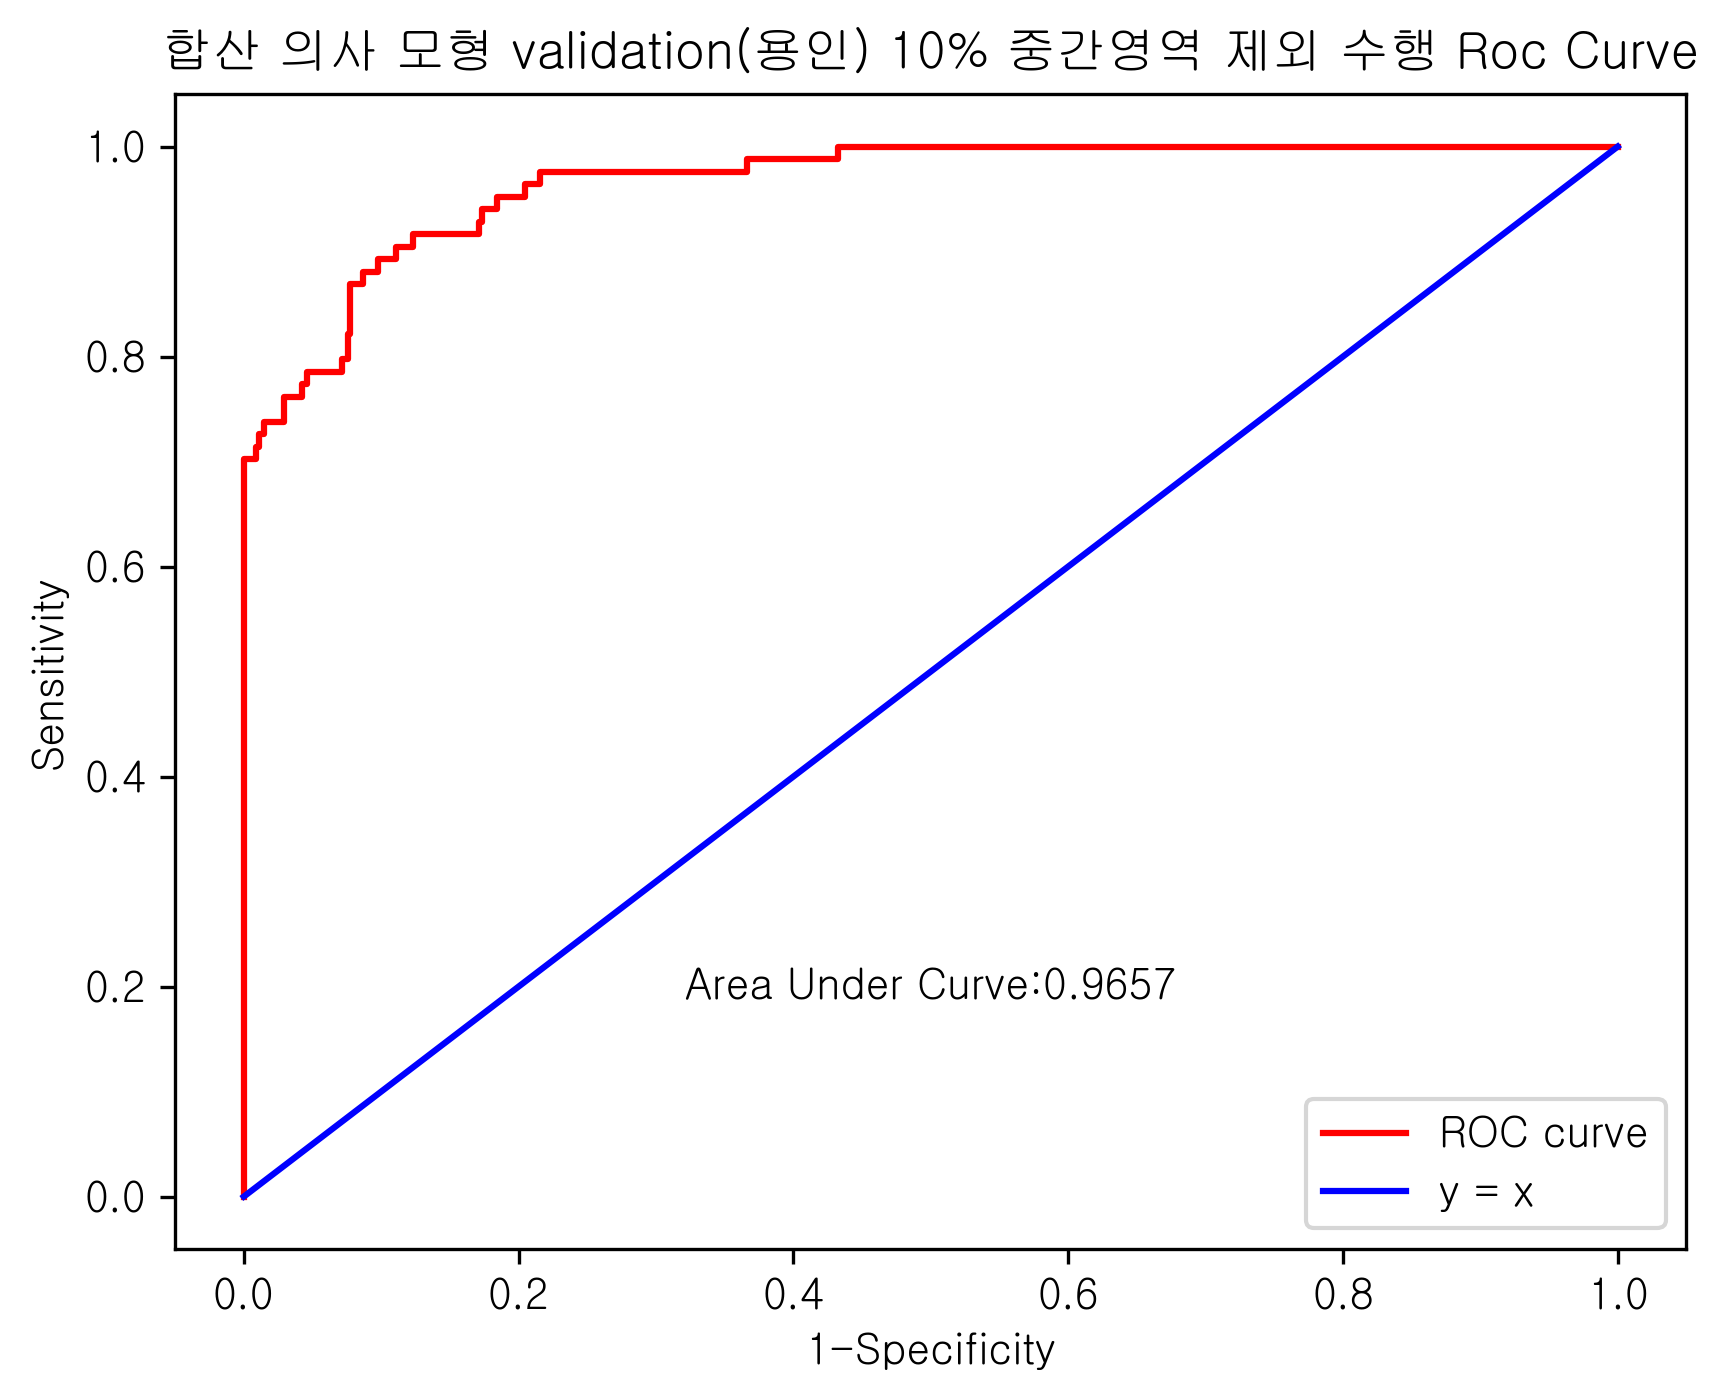

In [62]:
# roc curve, auc validation set
fpr, tpr, thresholds = roc_curve(np.array(ex_copy_no_middle_10['Biopsy_new']), ex_copy_no_middle_10['pred_prob'])

plt.figure(figsize=(6.5,5), dpi=300)

# auc 계산

plt.plot(fpr, tpr, color = 'red', label = 'ROC curve')
plt.plot([0, 1], [0, 1], color = 'blue', label = 'y = x') # y = x 직선 표시

auc = roc_auc_score(np.array(ex_copy_no_middle_10['Biopsy_new']), ex_copy_no_middle_10['pred_prob'])
plt.text(0.5, 0.2, f"Area Under Curve:{auc:.4f}", ha='center', va='center', fontsize=10)
plt.title('합산 의사 모형 validation(용인) 10% 중간영역 제외 수행 Roc Curve')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')

plt.legend() # 그래프 라벨 표시

plt.show()

In [63]:
print(classification_report(ex_copy_no_middle_10['Biopsy_new'], ex_copy_no_middle_10['pred']))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       543
           1       1.00      0.64      0.78        84

    accuracy                           0.95       627
   macro avg       0.97      0.82      0.88       627
weighted avg       0.95      0.95      0.95       627



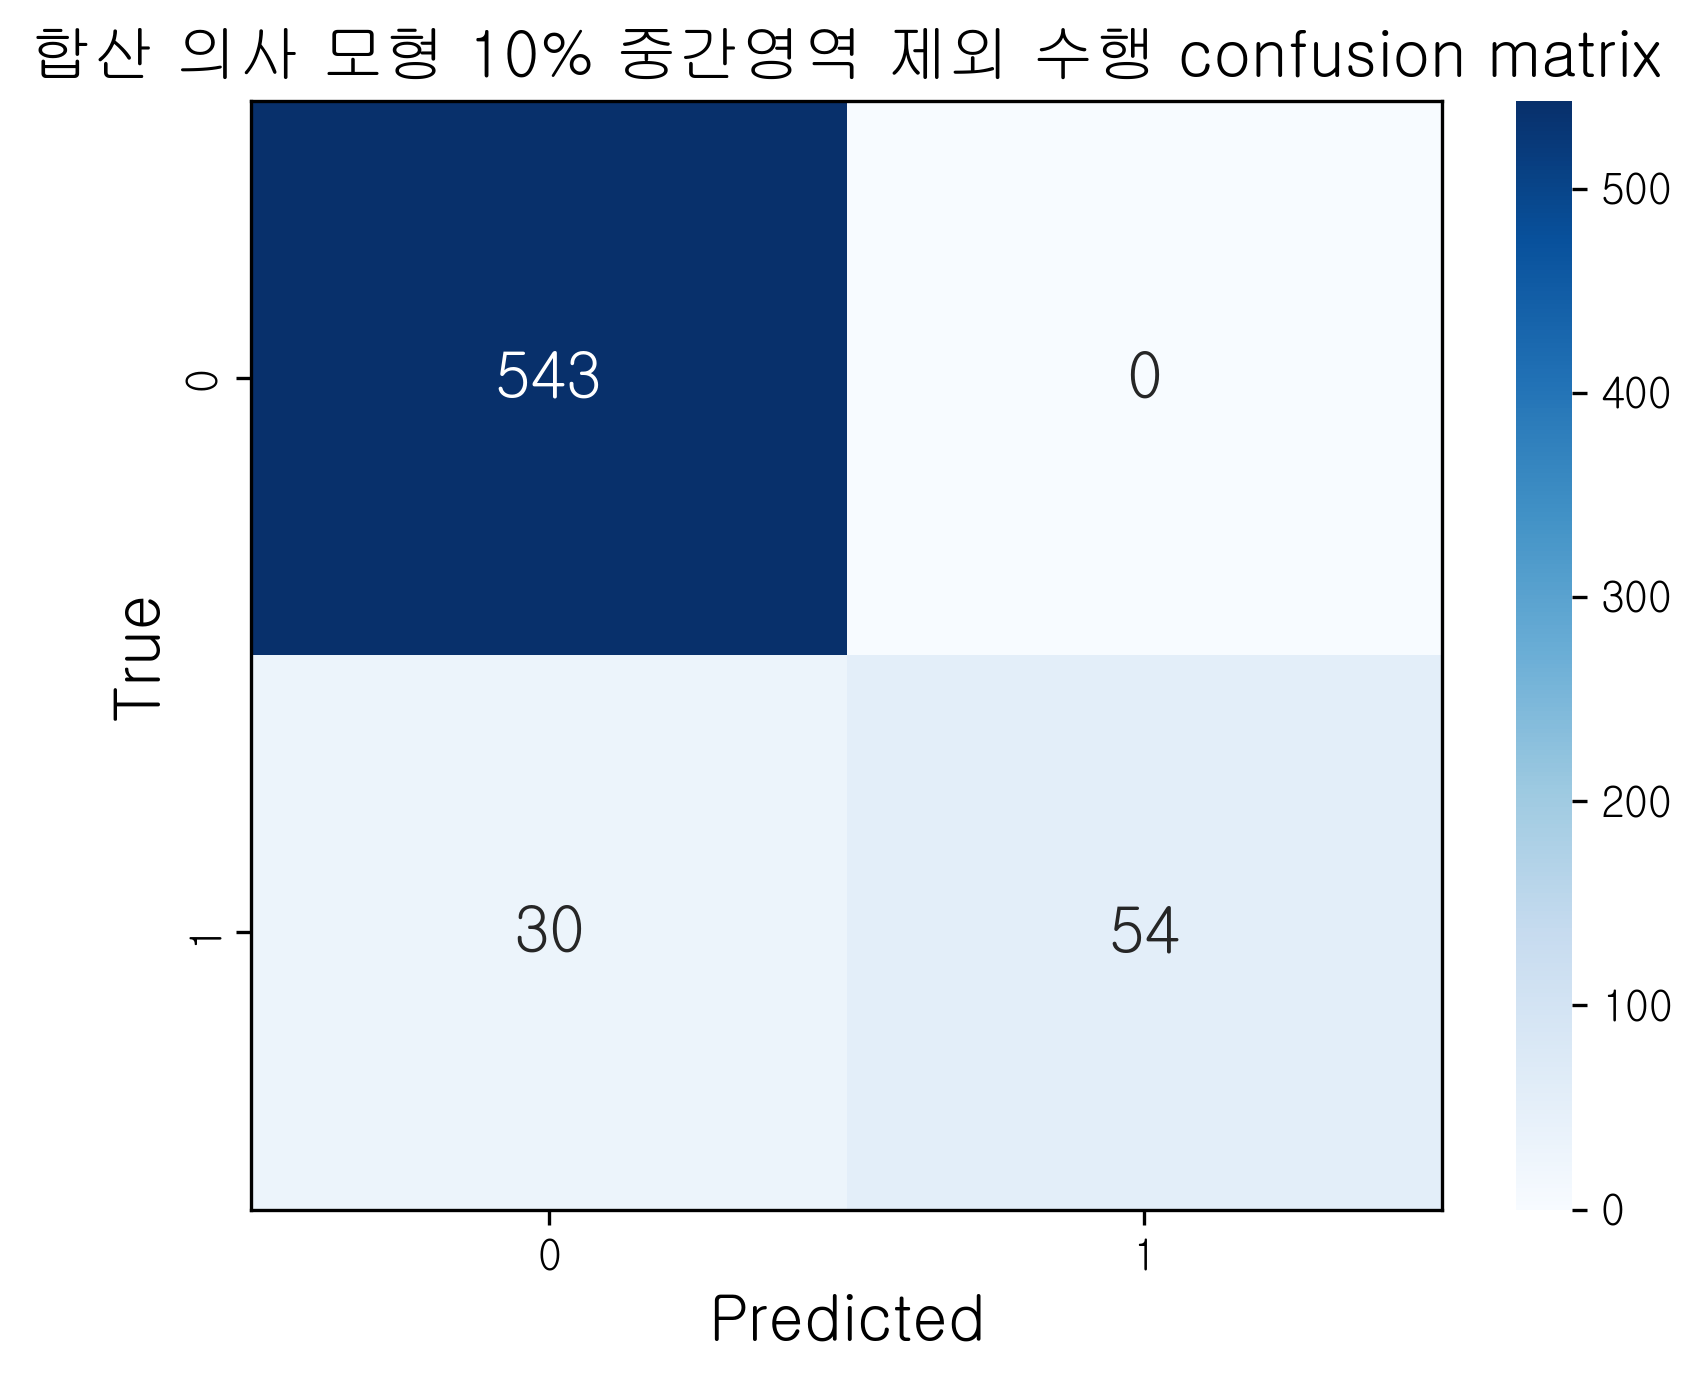

In [64]:
cm = confusion_matrix(ex_copy_no_middle_10['Biopsy_new'], ex_copy_no_middle_10['pred'])

plt.figure(dpi=300)
# Plot the confusion matrix with specific formatting for annotations
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Accessing the text elements of the heatmap and setting font properties
for _, spine in heatmap.spines.items():
    spine.set_visible(True)

for t in heatmap.texts:
    t.set_fontsize(15)  # Set the font size here

plt.title('합산 의사 모형 10% 중간영역 제외 수행 confusion matrix', fontsize = 15)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)
plt.show()

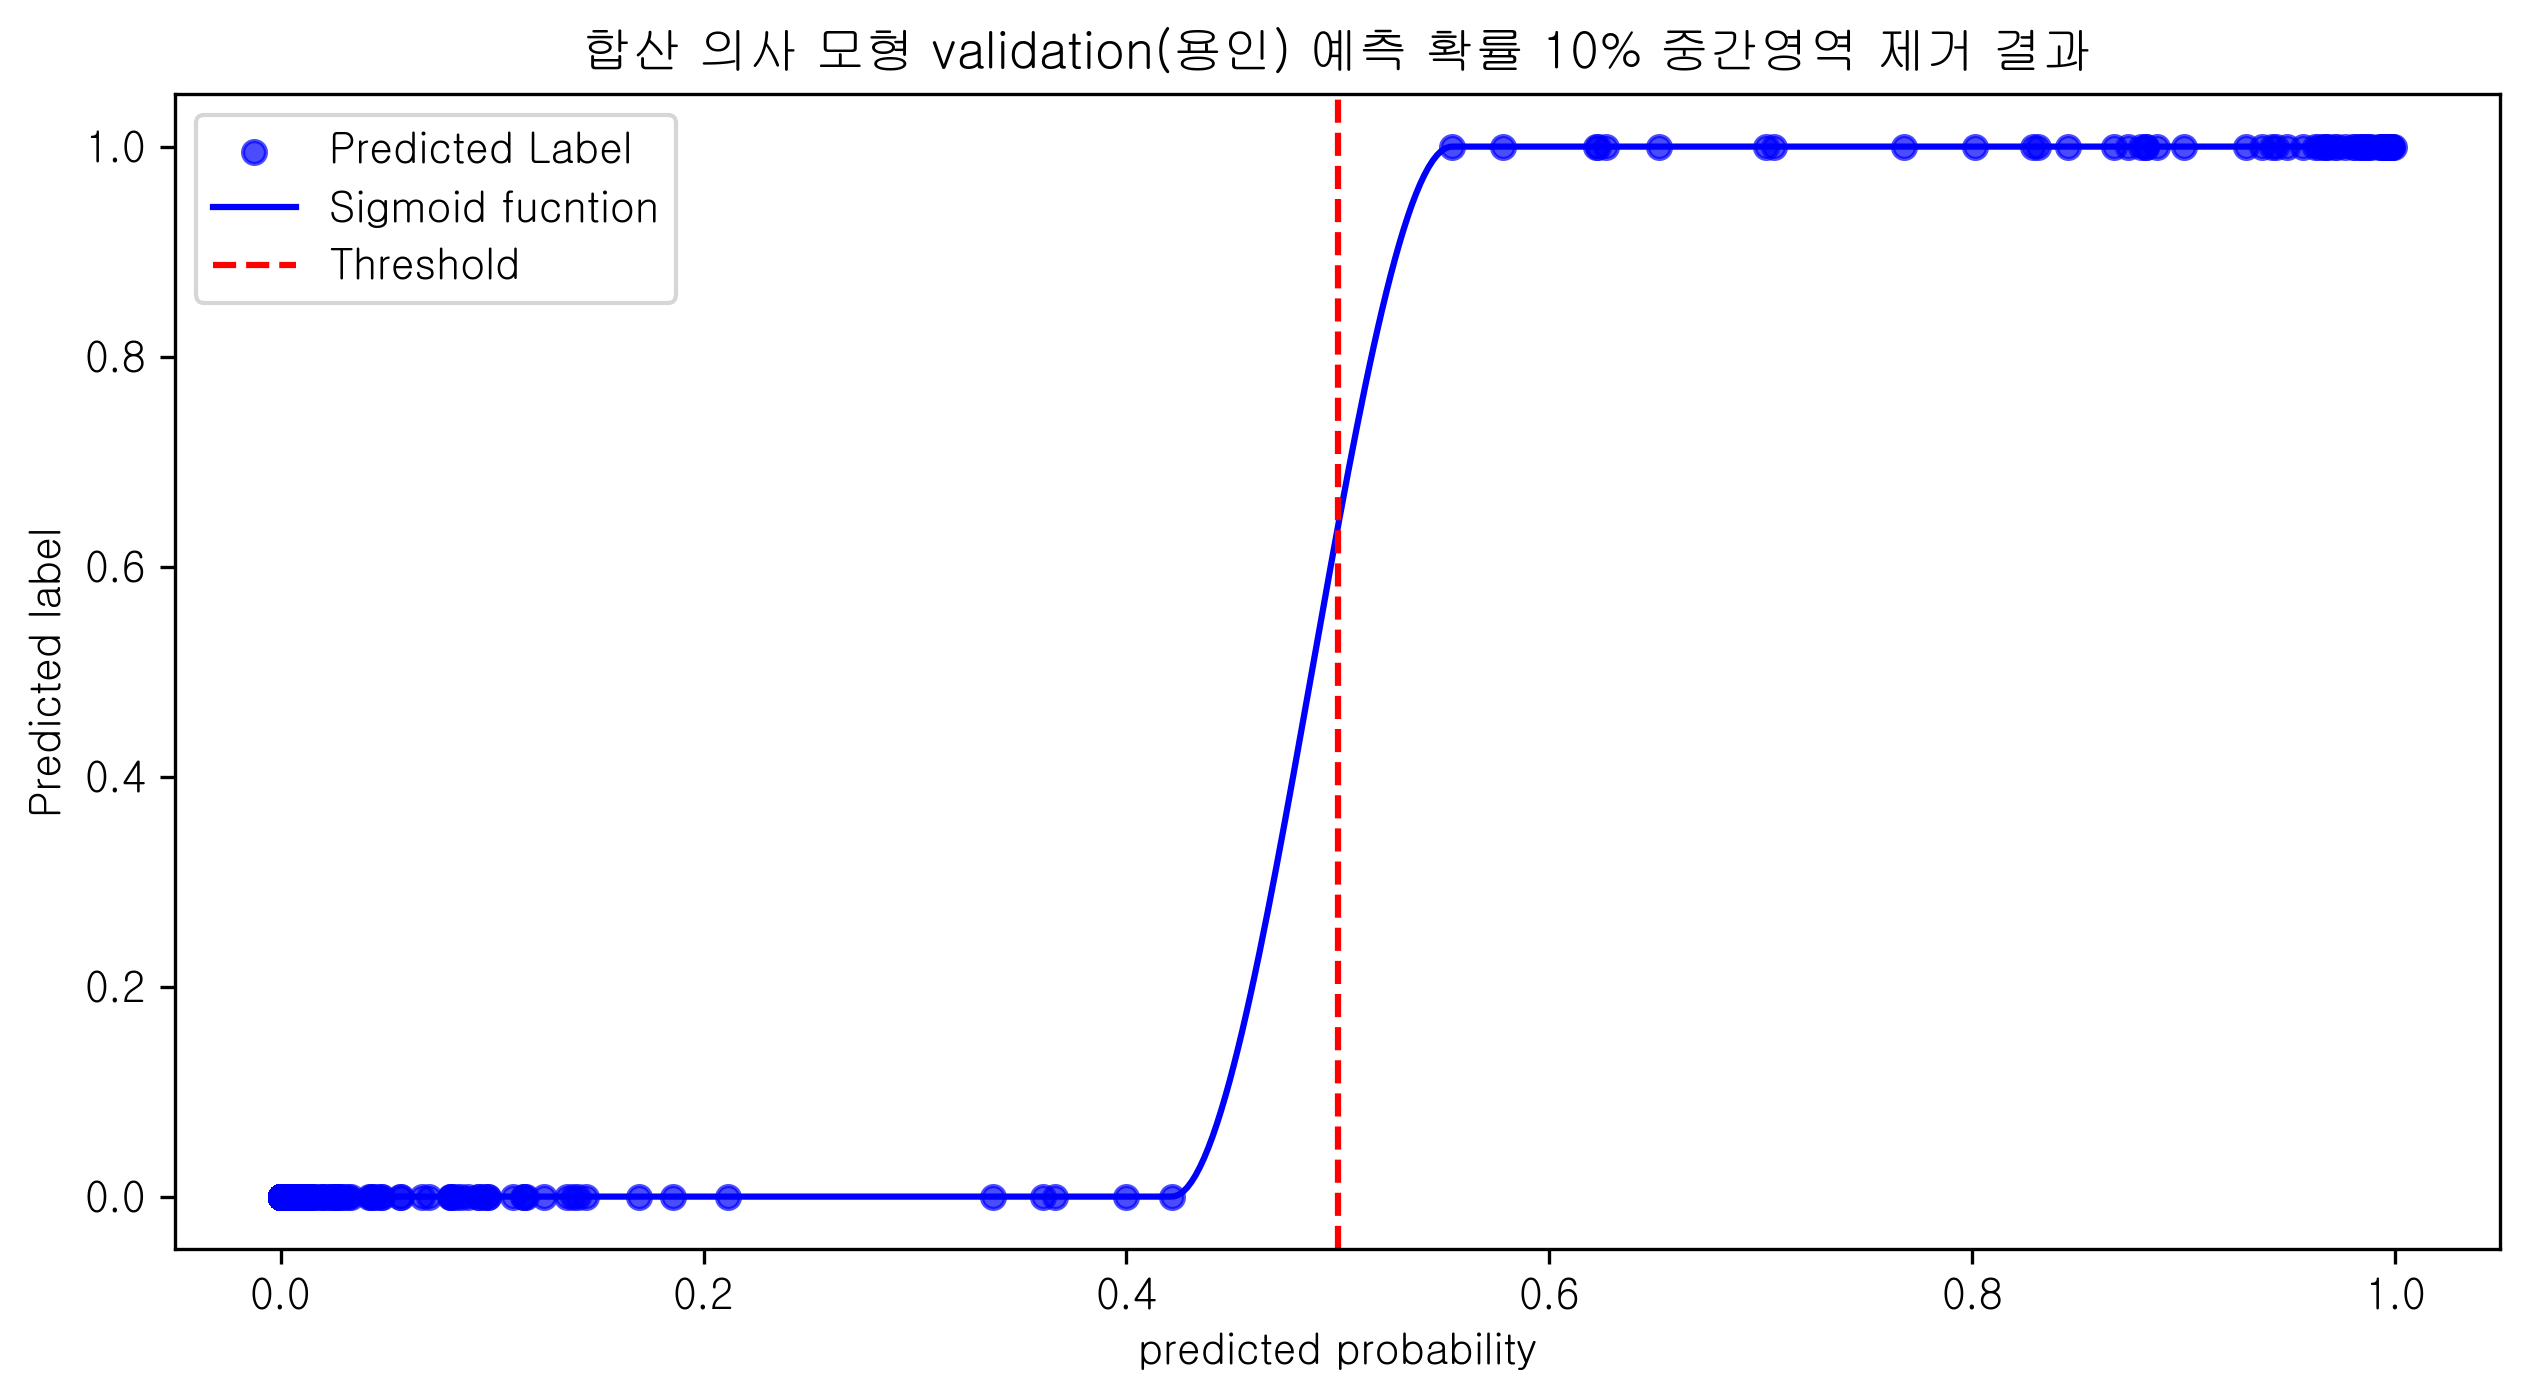

In [69]:
from scipy.interpolate import PchipInterpolator

# 데이터 포인트를 예측 확률에 따라 정렬
sorted_indices = np.argsort(middle_10_pred_prob)
sorted_ex_copy_pred_prob = middle_10_pred_prob[sorted_indices]
sorted_ex_copy_pred = middle_10_pred[sorted_indices]

# PchipInterpolator를 사용하여 보간 객체 생성
f = PchipInterpolator(sorted_ex_copy_pred_prob, sorted_ex_copy_pred)

# 보간 함수를 사용하여 곡선 생성을 위한 y 값 계산
x_new = np.linspace(min(sorted_ex_copy_pred_prob), max(sorted_ex_copy_pred_prob), 500)
y_smooth = f(x_new)

# 그래프 그리기
plt.figure(figsize=(10,5), dpi=300)
plt.scatter(middle_10_pred_prob, middle_10_pred, color='blue', label='Predicted Label', alpha=0.7, s=30)
plt.plot(x_new, y_smooth, color='blue', label='Sigmoid fucntion')

# 기타 그래프 설정
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')
plt.xlabel('predicted probability')
plt.ylabel('Predicted label')
plt.title('합산 의사 모형 validation(용인) 예측 확률 10% 중간영역 제거 결과')
plt.legend()
plt.grid(False)
plt.show()

### 20% 중간 영역 제외

In [70]:
# 8개 제외됨
ex_copy_no_middle = ex_copy[(ex_copy['pred_prob'] < 0.4) | (ex_copy['pred_prob'] > 0.6)].copy()
print(ex_copy_no_middle.shape)
ex_copy_no_middle.head()

(624, 20)


,age,sex,HTN,DM,plt,alb,bun,cr,eGFR,blood_dip,protein_dip,acr_urine,pcr_urine,glu,RBC,WBC,Biopsy,Biopsy_new,pred,pred_prob
1,38,1,0,0,441,4.4,14.0,1.02,92.805164,3.0,3.0,1224.4,1.8593,88,20,2,0,1,1,0.996576
2,43,1,1,1,196,4.5,9.8,0.62,121.494743,0.0,2.0,185.6,0.2984,276,2,2,0,0,0,0.000010
3,41,1,1,0,283,4.1,25.6,1.44,59.890404,0.0,0.0,8.0,0.0382,104,2,2,0,0,0,0.000205
4,62,1,0,0,186,4.4,14.2,0.65,104.269863,0.0,0.0,8.0,0.1232,90,2,2,0,0,0,0.000026
5,60,1,0,0,255,5.1,13.2,0.95,86.653354,0.0,3.0,868.3,1.3104,114,2,5,0,1,1,0.976329


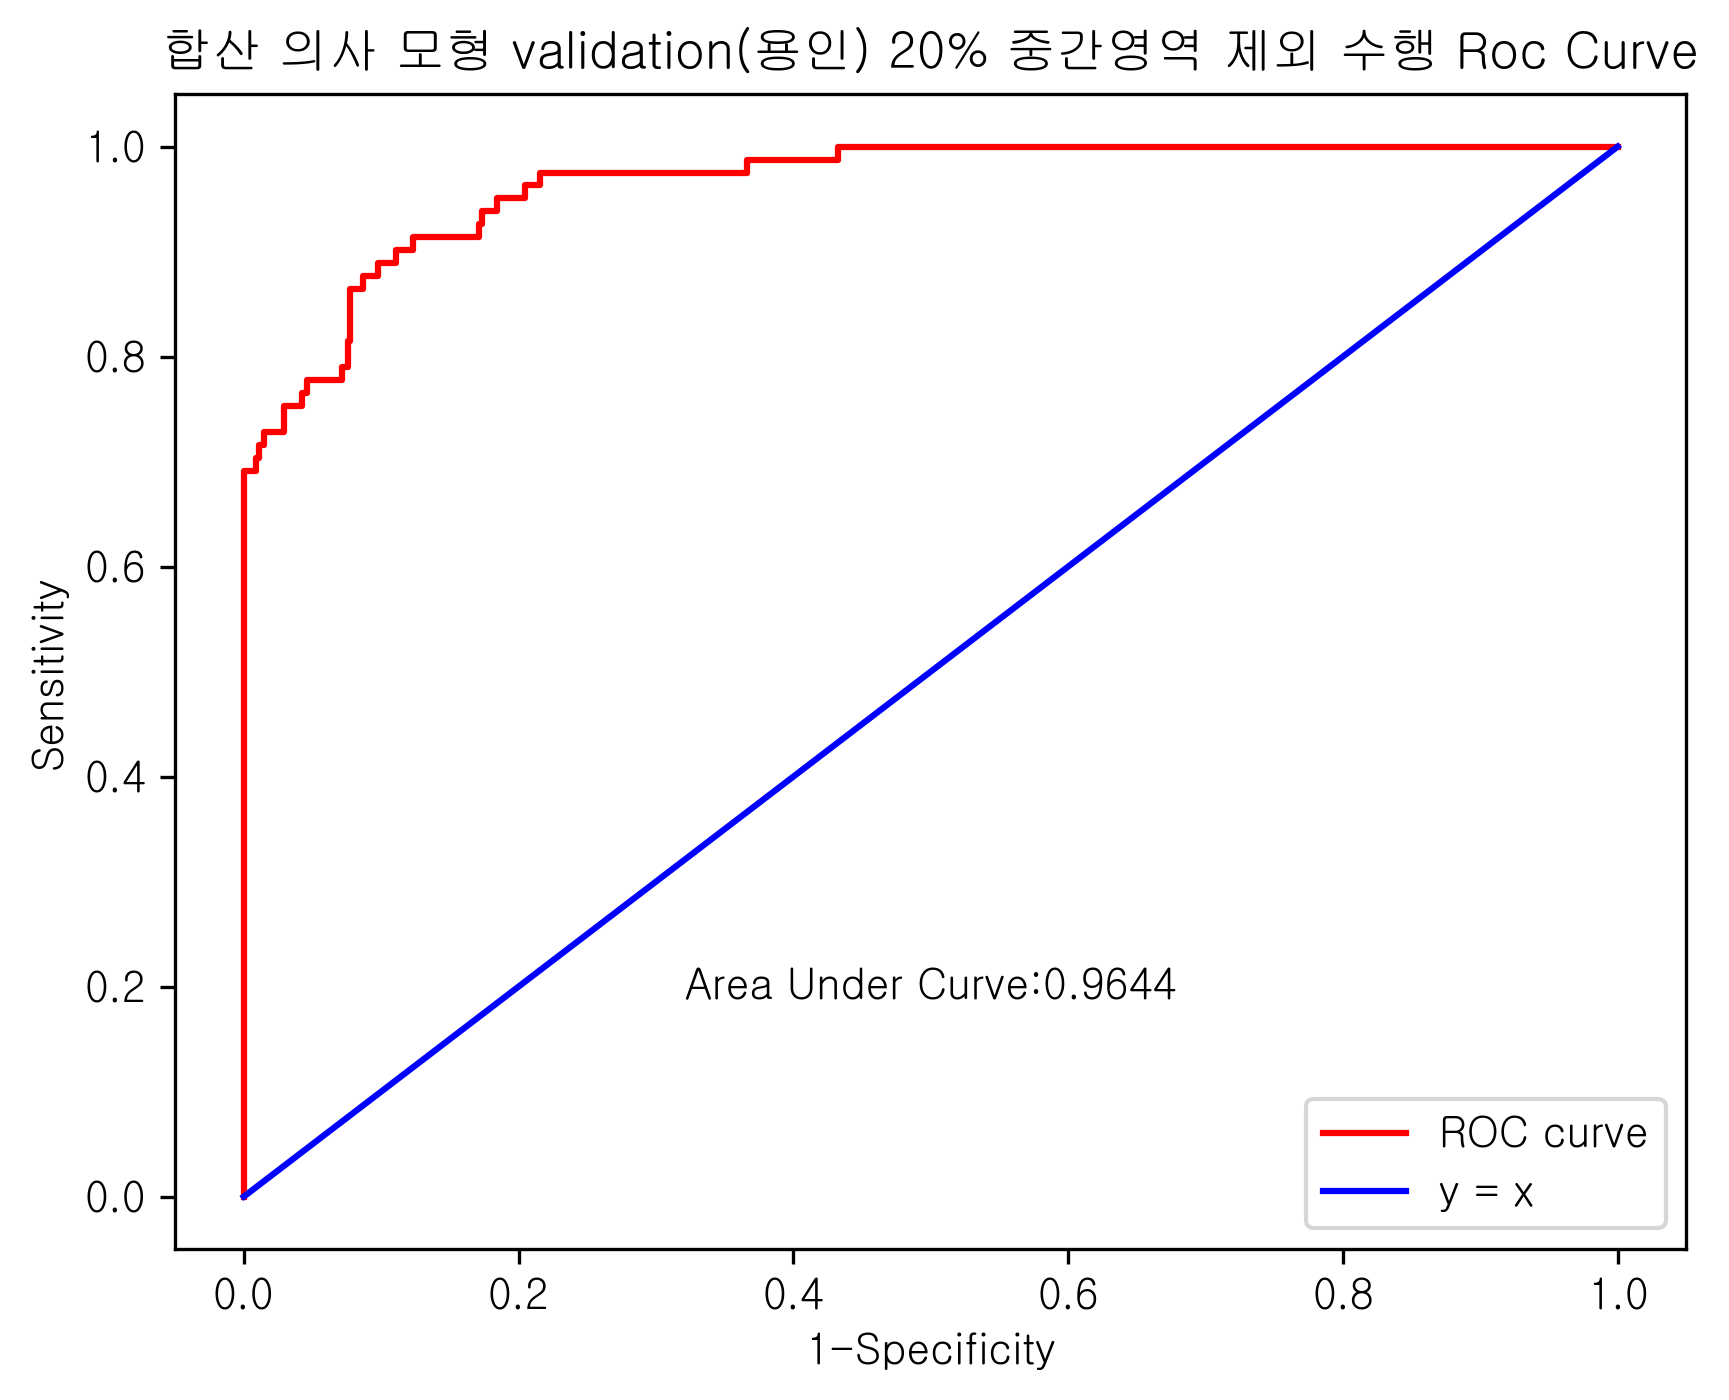

In [71]:
# roc curve, auc validation set
fpr, tpr, thresholds = roc_curve(np.array(ex_copy_no_middle['Biopsy_new']), ex_copy_no_middle['pred_prob'])

plt.figure(figsize=(6.5,5), dpi=300)

# auc 계산
plt.plot(fpr, tpr, color = 'red', label = 'ROC curve')
plt.plot([0, 1], [0, 1], color = 'blue', label = 'y = x') # y = x 직선 표시

auc = roc_auc_score(np.array(ex_copy_no_middle['Biopsy_new']), ex_copy_no_middle['pred_prob'])
plt.text(0.5, 0.2, f"Area Under Curve:{auc:.4f}", ha='center', va='center', fontsize=10)
plt.title('합산 의사 모형 validation(용인) 20% 중간영역 제외 수행 Roc Curve')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')

plt.legend() # 그래프 라벨 표시

plt.show()

In [72]:
print(classification_report(ex_copy_no_middle['Biopsy_new'], ex_copy_no_middle['pred']))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       543
           1       1.00      0.64      0.78        81

    accuracy                           0.95       624
   macro avg       0.97      0.82      0.88       624
weighted avg       0.96      0.95      0.95       624



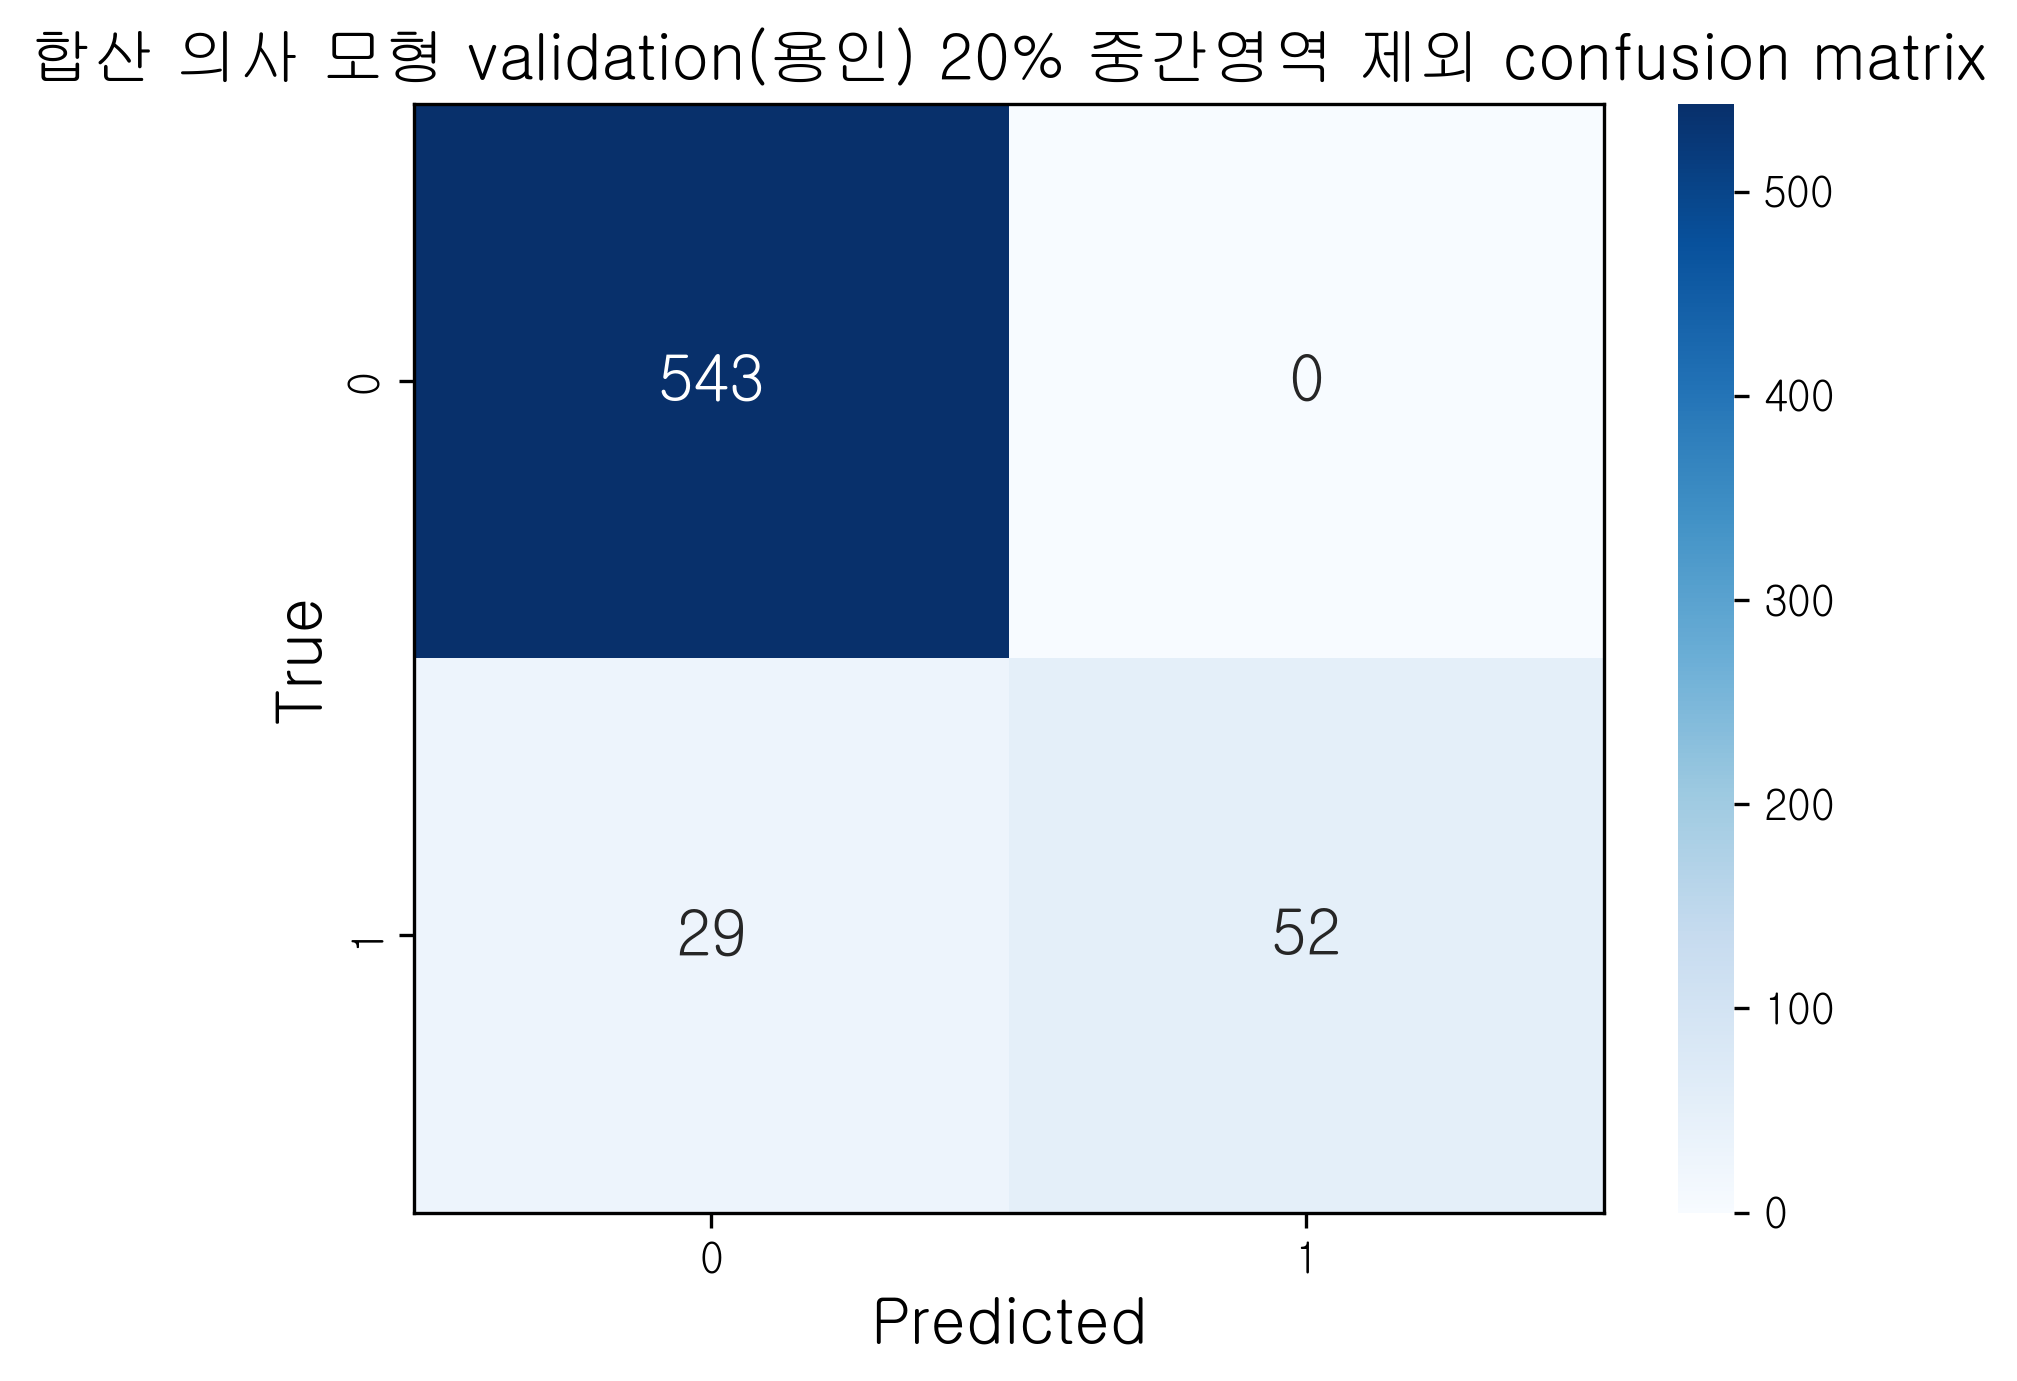

In [74]:
cm = confusion_matrix(ex_copy_no_middle['Biopsy_new'], ex_copy_no_middle['pred'])

plt.figure(dpi=300)
# Plot the confusion matrix with specific formatting for annotations
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Accessing the text elements of the heatmap and setting font properties
for _, spine in heatmap.spines.items():
    spine.set_visible(True)

for t in heatmap.texts:
    t.set_fontsize(15)  # Set the font size here

plt.title('합산 의사 모형 validation(용인) 20% 중간영역 제외 confusion matrix', fontsize = 15)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)
plt.show()

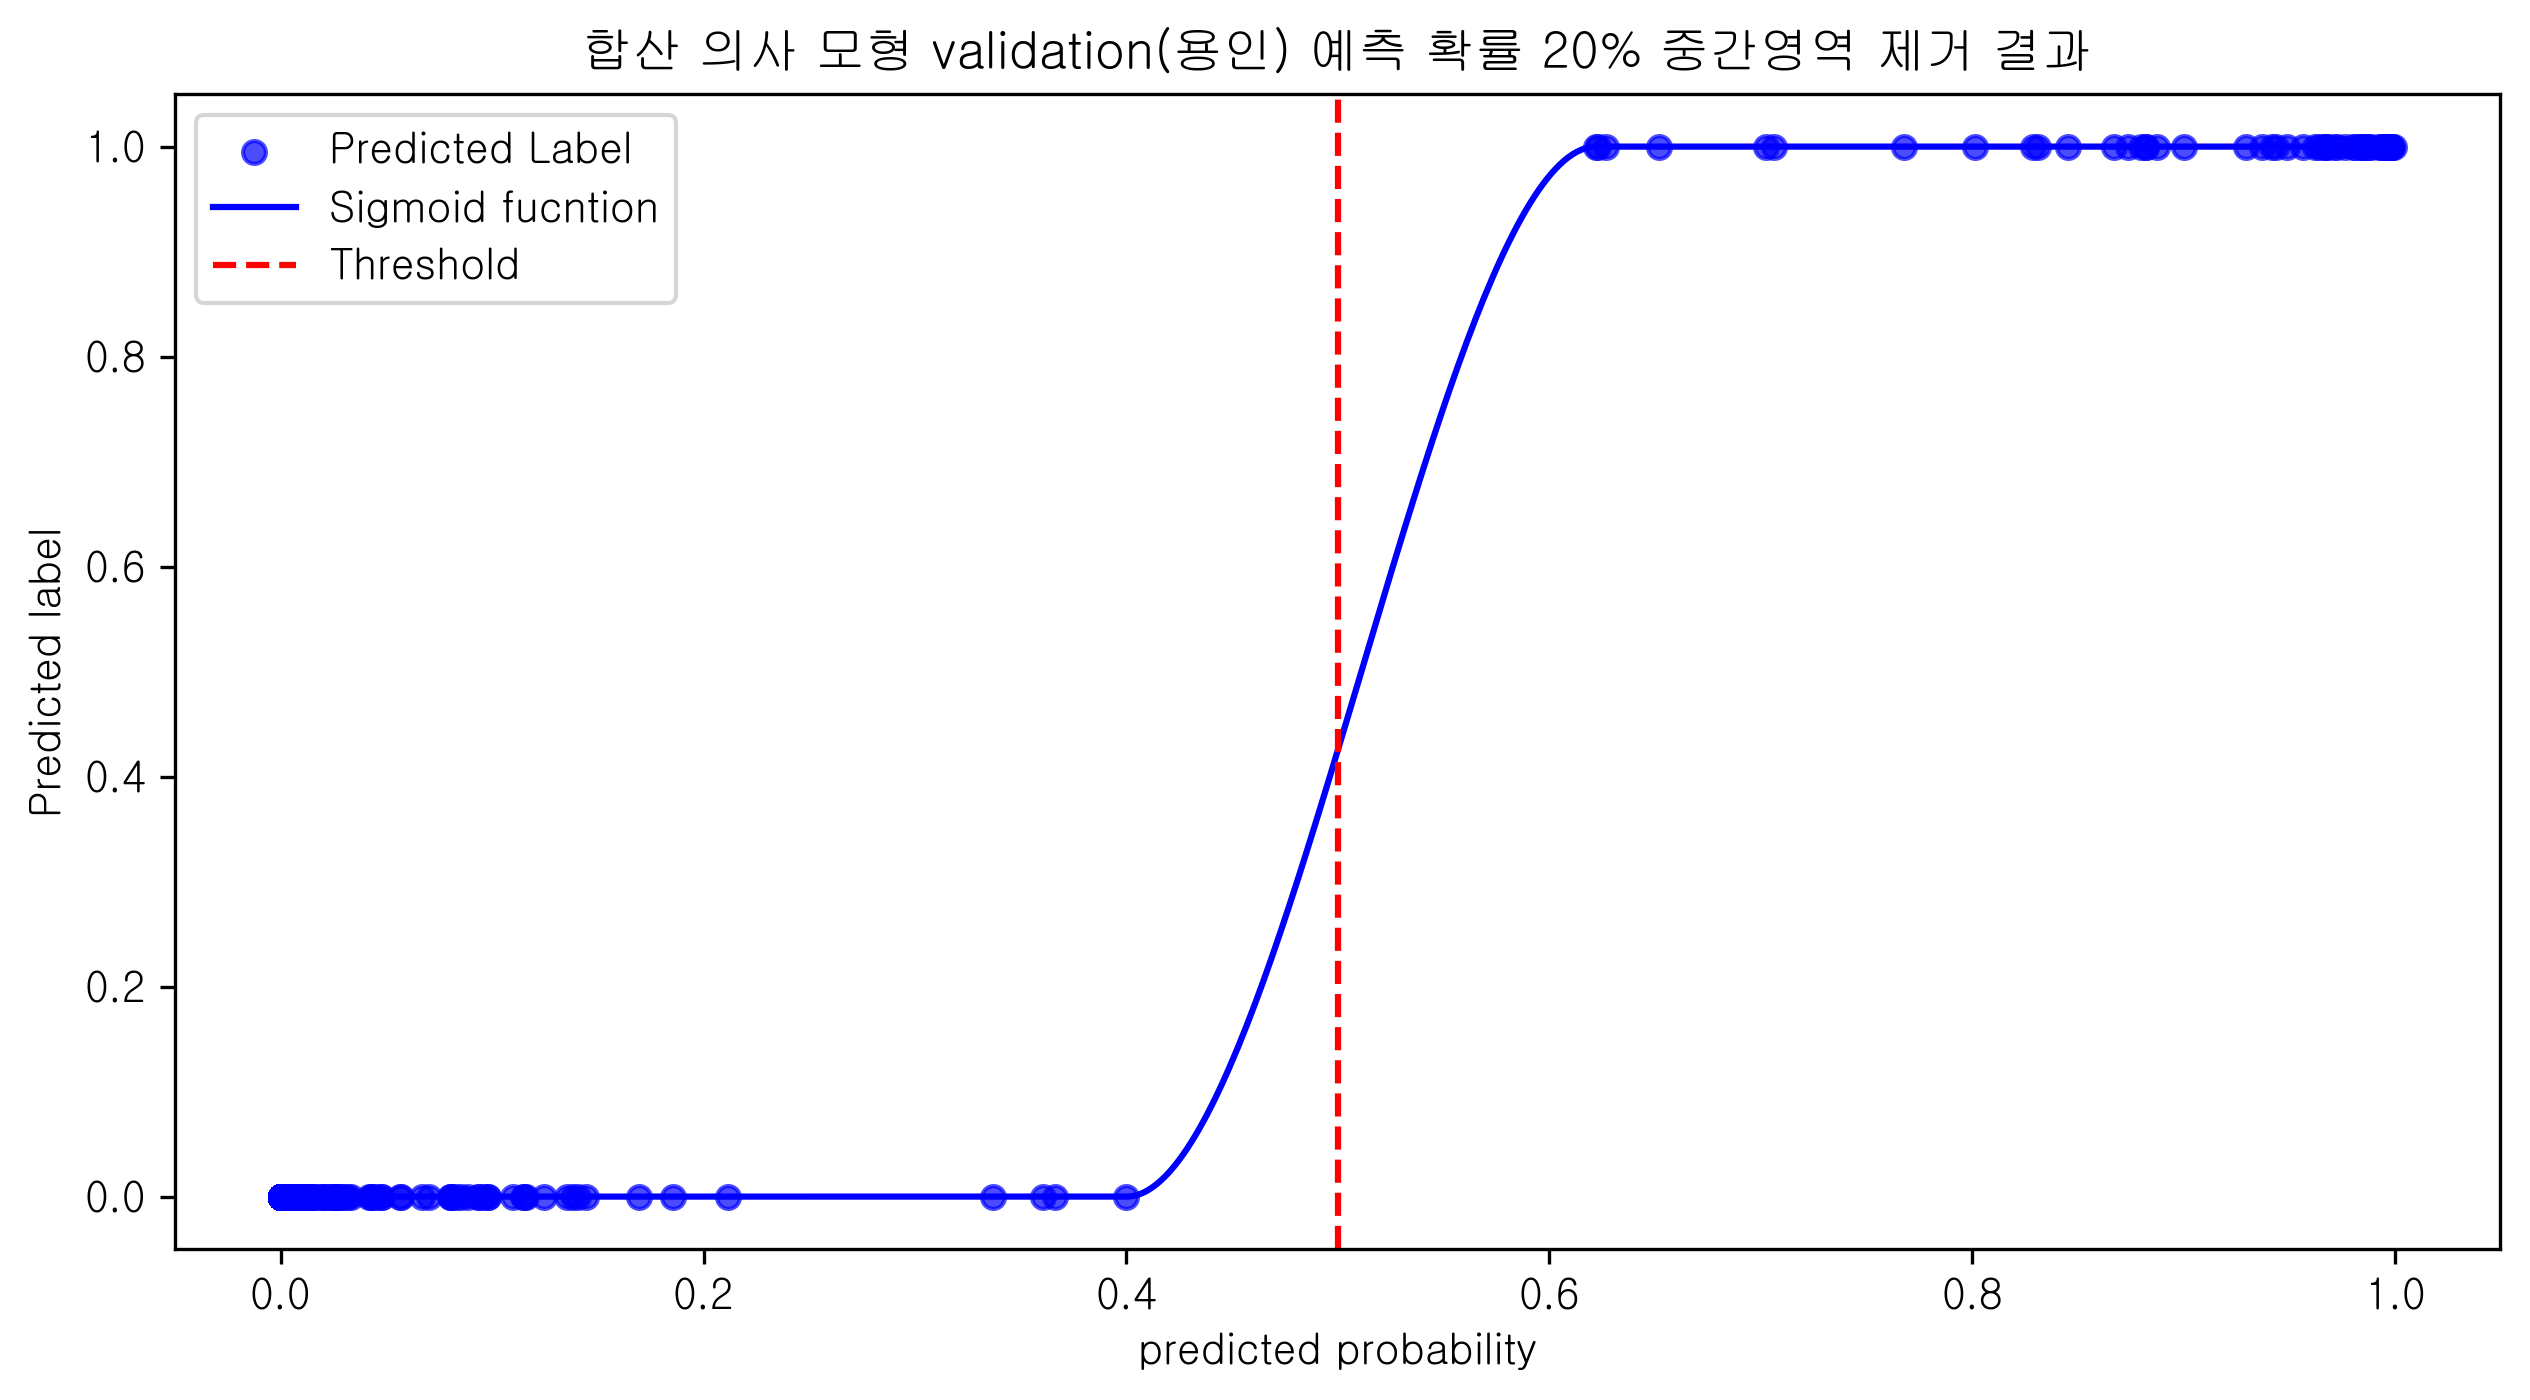

In [75]:
from scipy.interpolate import PchipInterpolator

# 격자 없이 
# 데이터 포인트를 예측 확률에 따라 정렬
sorted_indices = np.argsort(middle_pred_prob)
sorted_ex_copy_pred_prob = middle_pred_prob[sorted_indices]
sorted_ex_copy_pred = middle_pred[sorted_indices]

# PchipInterpolator를 사용하여 보간 객체 생성
f = PchipInterpolator(sorted_ex_copy_pred_prob, sorted_ex_copy_pred)

# 보간 함수를 사용하여 곡선 생성을 위한 y 값 계산
x_new = np.linspace(min(sorted_ex_copy_pred_prob), max(sorted_ex_copy_pred_prob), 500)
y_smooth = f(x_new)

# 그래프 그리기
plt.figure(figsize=(10,5), dpi=300)
plt.scatter(middle_pred_prob, middle_pred, color='blue', label='Predicted Label', alpha=0.7, s=30)
plt.plot(x_new, y_smooth, color='blue', label='Sigmoid fucntion')

# 기타 그래프 설정
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')
plt.xlabel('predicted probability')
plt.ylabel('Predicted label')
plt.title('합산 의사 모형 validation(용인) 예측 확률 20% 중간영역 제거 결과')
plt.legend()
plt.grid(False)
plt.show()